## Final Project

### Analysis of features extarcted from audio data

- link to dataset:

### Motivation and Goals

The goal of this project is to clasdify voice recoridngs as either male of female, based on numerical features extracted from the Mozilla common voice dataset.
The purpose of this project is ...


In [47]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer   
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from playsound import playsound
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, log_loss, RocCurveDisplay
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold



FULL_RUN=False

## Data Loading

In [2]:
list_of_files = ["data_en_5.csv","data_de_5.csv","data_es_5.csv","data_fr_5.csv","data_da_5.csv","data_se_5.csv"]
folder_path = "./data/"
data_frames = []

for file_name in list_of_files:
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        with open(file_path, "r") as file:
            data_frames.append(pd.read_csv(file))

data_raw = pd.concat(data_frames, ignore_index=True)

data_raw.head()

/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_22423/70944752.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames.append(pd.read_csv(file))
/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_22423/70944752.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames.append(pd.read_csv(file))
/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_22423/70944752.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames.append(pd.read_csv(file))
/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_22423/70944752.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames.append(pd.read_csv(file))


,client_id,path,sentence,sentence_domain,age,gender,accents,locale,mfcc_01_mean,mfcc_02_mean,...,spec_contrast_band_4_std,spec_contrast_band_5_std,spec_contrast_band_6_std,spec_contrast_band_7_std,spec_rolloff_mean,spec_rolloff_std,zcr_mean,zcr_std,rmse_mean,rmse_std
0,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070055.mp3,Hey,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-346.518280,105.766724,...,3.426842,4.632593,4.544755,3.958164,8989.213423,3783.708743,0.090629,0.042087,0.060498,0.114381
1,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070053.mp3,no,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-322.999481,126.325928,...,4.280022,3.408587,2.381304,4.629252,7763.446514,3417.324623,0.066695,0.032427,0.049127,0.084837
2,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070105.mp3,five,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-331.817749,117.011810,...,4.219483,3.785361,2.149989,4.760492,9540.267231,3227.213457,0.106078,0.038869,0.029110,0.057353
3,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070052.mp3,nine,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-332.498993,135.062897,...,4.019066,3.495409,1.738416,3.265927,8103.400735,2729.275878,0.065502,0.027279,0.026913,0.042086
4,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070093.mp3,Firefox,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-338.940430,107.349236,...,4.237970,3.737033,4.581891,4.229101,9500.395185,3109.524254,0.115977,0.054341,0.029288,0.053868


In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183670 entries, 0 to 183669
Data columns (total 96 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   client_id                  183670 non-null  object 
 1   path                       183670 non-null  object 
 2   sentence                   183595 non-null  object 
 3   sentence_domain            24 non-null      object 
 4   age                        182568 non-null  object 
 5   gender                     183670 non-null  object 
 6   accents                    131636 non-null  object 
 7   locale                     183670 non-null  object 
 8   mfcc_01_mean               183670 non-null  float64
 9   mfcc_02_mean               183670 non-null  float64
 10  mfcc_03_mean               183670 non-null  float64
 11  mfcc_04_mean               183670 non-null  float64
 12  mfcc_05_mean               183670 non-null  float64
 13  mfcc_06_mean               18

In [4]:
data_raw.describe(include="all")

,client_id,path,sentence,sentence_domain,age,gender,accents,locale,mfcc_01_mean,mfcc_02_mean,...,spec_contrast_band_4_std,spec_contrast_band_5_std,spec_contrast_band_6_std,spec_contrast_band_7_std,spec_rolloff_mean,spec_rolloff_std,zcr_mean,zcr_std,rmse_mean,rmse_std
count,183670,183670,183595,24,182568,183670,131636,183670,183670.000000,183670.000000,...,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000
unique,36738,183670,140372,10,9,2,658,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,372293e65cdab88771e028a4351651ab2eff64438ddafc...,clips/common_voice_en_22070055.mp3,Firefox,general,twenties,male_masculine,United States English,en,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,20,1,869,10,74945,143330,35715,106233,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-433.083453,106.725027,...,4.619814,4.847164,6.921225,6.550476,4920.925742,2871.320474,0.084152,0.071973,0.047341,0.053646
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.895697,27.527274,...,0.773090,0.951920,2.099385,2.942824,1824.650639,989.775650,0.039789,0.028838,0.035350,0.033410
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1131.370972,-8.795303,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-479.824127,89.726835,...,4.084150,4.195326,5.468441,4.796036,3611.233885,2097.006988,0.055889,0.051305,0.022227,0.028345
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-417.808914,107.633327,...,4.525914,4.711573,6.732120,5.815831,4602.441790,2794.098861,0.077148,0.068592,0.041500,0.050502
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-372.730217,124.976196,...,5.061872,5.361510,8.165126,7.197205,5952.463468,3543.561115,0.104689,0.089774,0.064625,0.073442


In [5]:
data_raw["age"].unique()

array(['twenties', 'teens', 'thirties', 'fourties', 'fifties', 'sixties',
       nan, 'seventies', 'eighties', 'nineties'], dtype=object)

In [6]:
with open("./data/WORLD-2024.csv", "r") as file:
    world_population_raw = pd.read_csv(file)

def map_to_bin(age_range):
    try:
        lower = int(age_range.split('-')[0])
    except (ValueError, IndexError):
        return None
    return (lower // 10) * 10

world_population = world_population_raw.copy()
world_population['age'] = world_population_raw['Age'].apply(map_to_bin)
world_population['count'] = world_population['M'] + world_population['F']

world_population=world_population.groupby('age', as_index=False)[['M', 'F', 'count']].sum()

print("Global population by age group")
world_population_table= PrettyTable()
world_population_table.field_names = ["Age", "F", "M", "Count"]
for age in world_population["age"].unique():
    female= world_population[world_population["age"] == age]["F"].values[0]
    male= world_population[world_population["age"] == age]["M"].values[0]
    count = world_population[world_population["age"] == age]["count"].values[0]
    world_population_table.add_row([age, female, male, count])
print(world_population_table)

world_population= world_population[(world_population["age"] > 0)&(world_population["age"] < 80)]
world_population['percentage_f'] = world_population['F'] / world_population['count'].sum()
world_population['percentage_m'] = world_population['M'] / world_population['count'].sum()

world_population_table= PrettyTable()
world_population_table.field_names = ["Age", "Count", "Percentage - Female", "Percentage - Male"]
for age in world_population["age"].unique():
    count = world_population[world_population["age"] == age]["count"].values[0]
    percentage_f = np.round(world_population[world_population["age"] == age]["percentage_f"].values[0]*100,2)
    percentage_m = np.round(world_population[world_population["age"] == age]["percentage_m"].values[0]*100,2)
    world_population_table.add_row([age, count, percentage_f, percentage_m])
print(world_population_table)

Global population by age group
+------+-----------+-----------+------------+
| Age  |     F     |     M     |   Count    |
+------+-----------+-----------+------------+
| 0.0  | 647571780 | 683880297 | 1331452077 |
| 10.0 | 646940513 | 689549048 | 1336489561 |
| 20.0 | 591939467 | 627801903 | 1219741370 |
| 30.0 | 583727408 | 612129215 | 1195856623 |
| 40.0 | 499876584 | 511145211 | 1011021795 |
| 50.0 | 444383233 | 438029375 | 882412608  |
| 60.0 | 335349756 | 308707292 | 644057048  |
| 70.0 | 207266969 | 169569804 | 376836773  |
| 80.0 |  84361120 |  55509075 | 139870195  |
| 90.0 |  16467366 |  7180149  |  23647515  |
+------+-----------+-----------+------------+
+------+------------+---------------------+-------------------+
| Age  |   Count    | Percentage - Female | Percentage - Male |
+------+------------+---------------------+-------------------+
| 10.0 | 1336489561 |         9.7         |       10.34       |
| 20.0 | 1219741370 |         8.88        |        9.42       |
| 30.

In [7]:
def transform_age(age):
    if age=="teens":
        return 10
    elif age=="twenties":
        return 20
    elif age=="thirties":
        return 30
    elif age=="fourties":
        return 40
    elif age=="fifties":
        return 50
    elif age=="sixties":
        return 60
    elif age=="seventies":
        return 70
    elif isinstance(age, (int, float)):
        return age
    else:
        return None

data_raw["age"] = data_raw["age"].apply(transform_age)
print(f'dropped {data_raw["age"].isnull().sum()} rows')
data_raw = data_raw.dropna(subset=["age"])

# print counts
def generate_age_count_table(df):
    """
    Function to generate a PrettyTable with age counts
    :param df: DataFrame containing an 'age' column
    :return: PrettyTable object
    """
    table = PrettyTable()
    table.field_names = ["Age", "F", "M", "Count"]
    for age in sorted(df["age"].unique()):
        female_count = df[(df["age"] == age) & (df["gender"] == "female_feminine")].shape[0]
        male_count = df[(df["age"] == age) & (df["gender"] =="male_masculine")].shape[0]
        count = df[df["age"] == age].shape[0]
        table.add_row([age,female_count, male_count, count])
    return table

# Generate and print the table
table = generate_age_count_table(data_raw)
print(table)

dropped 1414 rows
+------+-------+-------+-------+
| Age  |   F   |   M   | Count |
+------+-------+-------+-------+
| 10.0 |  4652 | 16107 | 20759 |
| 20.0 | 15995 | 58950 | 74945 |
| 30.0 |  7393 | 32188 | 39581 |
| 40.0 |  4698 | 18513 | 23211 |
| 50.0 |  4434 |  9781 | 14215 |
| 60.0 |  2206 |  4969 |  7175 |
| 70.0 |  591  |  1779 |  2370 |
+------+-------+-------+-------+


In [8]:
def histograms(data):
    """
    Function to plot histograms of the dataframe
    :param data: DataFrame
    :return: None
    """
    data.hist(figsize=(20, 20), bins=50, color='black')
    plt.suptitle('Histograms (50 bins) of all features', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    
if FULL_RUN:   
    histograms(data_raw)

In [9]:
# histograms by gender
def histogram_by_gender(feature):
    
    female_feminine = data_raw['gender'] == 'female_feminine'
    feature_female = feature[female_feminine]
    
    male_masculine = data_raw['gender'] == 'male_masculine'
    feature_male = feature[male_masculine]
    
    plt.figure(figsize=(10, 5))
    plt.hist(feature_female, bins=50, color='pink', alpha=0.5)
    plt.hist(feature_male, bins=50, color='blue', alpha=0.5)
    plt.title(f'Histogram of {feature.columns[0]}')
    plt.show()

if FULL_RUN: 
    histogram_by_gender(data_raw[['spec_bandwidth_mean']])
    histogram_by_gender(data_raw[['spec_contrast_band_1_mean']])

        

In [10]:
col_to_log_transform = ['spec_contrast_band_7_mean', 'spec_contrast_band_7_std', 'rmse_mean', 'rmse_std']

In [11]:
# drop sentence_domain & exclude duplicate speakers
try:
    data_sampled = data_raw.groupby("client_id", group_keys=False).apply(
    lambda g: pd.concat([g.drop_duplicates("locale").head(5), g.head(5 - len(g.drop_duplicates("locale")))]))
    #data_sampled=data_raw[data_raw["locale"]=="en"]
    data_sampled = data_sampled.drop(columns=["sentence_domain"])
except:
    print("Column sentence_domain already dropped")

/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_22423/4268570829.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_sampled = data_raw.groupby("client_id", group_keys=False).apply(


In [12]:
# First histogram
if FULL_RUN:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    np.log(data_sampled['rmse_mean'] + 1e-10).hist(bins=200, ax=axes[0], color='black')
    # data_raw['rmse_mean'].hist(bins=200, ax=axes[0], color='black')
    axes[0].set_title('Before Dropping Quiet Audio Files')

## TO DO: PROPER OUTLIER DETECTION

# Dropping quiet audio files
bool_mask_quiet = data_sampled["rmse_mean"] < 0.001
data_clean = data_sampled[~bool_mask_quiet]
print(f"Samples dropped: {data_sampled.shape[0]-data_clean.shape[0]}")
print(f"Samples left: {data_clean.shape[0]}")

# Second histogram
if FULL_RUN:
    np.log(data_clean['rmse_mean'] + 1e-10).hist(bins=200, ax=axes[1], color='black')
    # data_raw['rmse_mean'].hist(bins=200, ax=axes[1], color='black')
    axes[1].set_title('After Dropping Quiet Audio Files')

    plt.suptitle('Logarithm of rmse_mean', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    



Samples dropped: 952
Samples left: 175523


In [13]:
""" #Undersample based on the demographic data
data_reduced = pd.DataFrame(columns=data_raw.columns)
for age in demographically_based_count["age"].unique():
    
    count_f = demographically_based_count[demographically_based_count["age"] == age]["count_f"].values[0].astype(int)
    count_m = demographically_based_count[demographically_based_count["age"] == age]["count_m"].values[0].astype(int)
    age_group_f = data_raw[(data_raw["age"] == age) & (data_raw["gender"] =="female_feminine")]
    age_group_m = data_raw[(data_raw["age"] == age) & (data_raw["gender"] =="male_masculine")]
    if len(age_group_f) > count_f:
        age_group_f = age_group_f.sample(n=count_f, random_state=27)
    if len(age_group_m) > count_m:
        age_group_m = age_group_m.sample(n=count_m, random_state=27)
    data_reduced = pd.concat([data_reduced, age_group_f, age_group_m], ignore_index=True)
data_reduced = data_reduced.sample(frac=1, random_state=27).reset_index(drop=True)


# Undersample the data
#data_raw = data_raw.groupby("age").apply(lambda x: x.sample(n=min(len(x)), random_state=27)).reset_index(drop=True)

table = generate_age_count_table(data_reduced)
print(table) """

' #Undersample based on the demographic data\ndata_reduced = pd.DataFrame(columns=data_raw.columns)\nfor age in demographically_based_count["age"].unique():\n    \n    count_f = demographically_based_count[demographically_based_count["age"] == age]["count_f"].values[0].astype(int)\n    count_m = demographically_based_count[demographically_based_count["age"] == age]["count_m"].values[0].astype(int)\n    age_group_f = data_raw[(data_raw["age"] == age) & (data_raw["gender"] =="female_feminine")]\n    age_group_m = data_raw[(data_raw["age"] == age) & (data_raw["gender"] =="male_masculine")]\n    if len(age_group_f) > count_f:\n        age_group_f = age_group_f.sample(n=count_f, random_state=27)\n    if len(age_group_m) > count_m:\n        age_group_m = age_group_m.sample(n=count_m, random_state=27)\n    data_reduced = pd.concat([data_reduced, age_group_f, age_group_m], ignore_index=True)\ndata_reduced = data_reduced.sample(frac=1, random_state=27).reset_index(drop=True)\n\n\n# Undersample 

In [14]:
#Legacy weighting of the data
def calculate_weights(data_clean): 
    weights_df = world_population.melt(
        id_vars="age", 
        value_vars=["F", "M"], 
        var_name="gender", 
        value_name="population_count"
    )

    # Map gender to full names
    weights_df["gender"] = weights_df["gender"].map(
        {"F": "female_feminine", "M": "male_masculine"}
    )

    # Add percentage columns back to the melted DataFrame
    weights_df["percentage"] = weights_df.apply(
        lambda row: row["population_count"] / weights_df["population_count"].sum(), axis=1
    )

    # STEP 2: Compute sample proportions from your dataset
    sample_counts = data_clean.groupby(["age","gender"]).size().reset_index(name="sample_count")
    total_sample_count = len(data_clean)
    sample_counts["sample_proportion"] = sample_counts["sample_count"] / total_sample_count

    # STEP 3: Merge and calculate weights
    weights_df = pd.merge(
        weights_df, 
        sample_counts, 
        on=["age", "gender"], 
        how="inner"
    )

    def adapted_sigmoid_scaling(w_raw):
        if w_raw < 1:
            return w_raw
        else:
            return np.log1p(w_raw)
    
    # Calculate sample weights
    weights_df["sample_weight"] = weights_df["percentage"] / weights_df["sample_proportion"]
    weights_df["log_sample_weight"] = weights_df["sample_weight"].apply(adapted_sigmoid_scaling)
    return weights_df


#Output to verify proportions and weights
weights_initial = calculate_weights(data_clean)
pd.set_option('display.float_format', lambda x: f'{x:0.4f}')
print("\n=== Age × Gender Weight Summary ===")
print(weights_initial[["age", "gender", "percentage", "sample_proportion", "sample_weight"]].sort_values(by=["age", "gender"]).reset_index(drop=True))


=== Age × Gender Weight Summary ===
       age           gender  percentage  sample_proportion  sample_weight
0  10.0000  female_feminine      0.0970             0.0255         3.8038
1  10.0000   male_masculine      0.1034             0.0885         1.1683
2  20.0000  female_feminine      0.0888             0.0855         1.0383
3  20.0000   male_masculine      0.0942             0.3227         0.2919
4  30.0000  female_feminine      0.0876             0.0398         2.1987
5  30.0000   male_masculine      0.0918             0.1757         0.5227
6  40.0000  female_feminine      0.0750             0.0255         2.9352
7  40.0000   male_masculine      0.0767             0.1026         0.7476
8  50.0000  female_feminine      0.0667             0.0248         2.6916
9  50.0000   male_masculine      0.0657             0.0549         1.1972
10 60.0000  female_feminine      0.0503             0.0123         4.0878
11 60.0000   male_masculine      0.0463             0.0283         1.6367
1

In [15]:
def constrained_undersample(
    data_clean,
    world_population,
    total_samples=10_000,
    seed=27,
    redistribute_shortfall=True
):
    np.random.seed(seed)

    # Prepare world_population long format
    pop_f = world_population[['age', 'percentage_f']].rename(columns={'percentage_f': 'percentage'})
    pop_f['gender'] = 'female_feminine'
    pop_m = world_population[['age', 'percentage_m']].rename(columns={'percentage_m': 'percentage'})
    pop_m['gender'] = 'male_masculine'
    pop_long = pd.concat([pop_f, pop_m], ignore_index=True)

    # Normalize percentages to sum to 1 (in case of small drift)
    pop_long['percentage'] = pop_long['percentage'] / pop_long['percentage'].sum()

    # Compute target counts per stratum
    pop_long['target_count'] = (pop_long['percentage'] * total_samples).round().astype(int)

    # Actual counts in your data_clean
    actual_counts = data_clean.groupby(['age', 'gender']).size().reset_index(name='available_count')

    # Merge target + available
    strata = pop_long.merge(actual_counts, on=['age', 'gender'], how='left').fillna({'available_count': 0})
    strata['available_count'] = strata['available_count'].astype(int)

    # Allocate samples — take min(target, available)
    strata['samples_taken'] = strata[['target_count', 'available_count']].min(axis=1)

    total_taken = strata['samples_taken'].sum()
    shortfall = total_samples - total_taken

    strata['final_sample_count'] = strata['samples_taken']  # Default if no redistribution

    # Redistribute shortfall if requested
    if redistribute_shortfall and shortfall > 0:
        strata['surplus'] = strata['available_count'] - strata['samples_taken']
        strata['can_take_more'] = strata['surplus'] > 0

        if strata['can_take_more'].any():
            surplus_total = strata.loc[strata['can_take_more'], 'surplus'].sum()
            strata['extra_allocation'] = 0

            # Proportional allocation of shortfall
            strata.loc[strata['can_take_more'], 'extra_allocation'] = (
                (strata['surplus'] / surplus_total) * shortfall
            ).round().astype(int)

            # Ensure no over-allocation
            strata['final_sample_count'] = strata['samples_taken'] + strata['extra_allocation']
            strata['final_sample_count'] = strata[['final_sample_count', 'available_count']].min(axis=1)

 
    # Sample from data_clean
    sampled_dfs = []
    for _, row in strata.iterrows():
        mask = (data_clean['age'] == row['age']) & (data_clean['gender'] == row['gender'])
        df_group = data_clean[mask]
        n_samples = row['final_sample_count']
        if n_samples > 0 and not df_group.empty:
            sampled_group = df_group.sample(n=n_samples, random_state=seed)
            sampled_dfs.append(sampled_group)

    if sampled_dfs:
        data_reduced = pd.concat(sampled_dfs, ignore_index=True)
    else:
        # Return empty df with same columns as data_clean
        data_reduced = data_clean.iloc[0:0].copy()

    print(strata[['age', 'gender', 'available_count', 'target_count', 'final_sample_count']])
    print(f"Total samples taken: {data_reduced.shape[0]}")
    print(f"Male to Female ratio: {data_reduced['gender'].value_counts().to_dict()}")

    return data_reduced


data_reduced = constrained_undersample(
    data_clean,
    world_population,
    total_samples=60000,
    redistribute_shortfall=False,
)


       age           gender  available_count  target_count  final_sample_count
0  10.0000  female_feminine             4478          5823                4478
1  20.0000  female_feminine            15010          5328                5328
2  30.0000  female_feminine             6990          5254                5254
3  40.0000  female_feminine             4484          4499                4484
4  50.0000  female_feminine             4347          4000                4000
5  60.0000  female_feminine             2160          3018                2160
6  70.0000  female_feminine              600          1865                 600
7  10.0000   male_masculine            15540          6206                6206
8  20.0000   male_masculine            56637          5650                5650
9  30.0000   male_masculine            30837          5509                5509
10 40.0000   male_masculine            18003          4600                4600
11 50.0000   male_masculine             9633        

In [44]:
# Data frames 
y= data_reduced[["gender", "age", "locale"]]
X= data_reduced.drop(columns=["gender", "age", "accents", "locale"])


# Perform the train test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=27)
for train_full_index, test_index in sss.split(X,  y['age'].astype(str) + "-" + y['gender']):
    X_train_full = X.iloc[train_full_index]
    y_train_full = y.iloc[train_full_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

# Further split the full training data set into training and validation
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=27)
for train_index, val_index in sss_train_val.split(X_train_full, y_train_full['age'].astype(str) + "-" + y_train_full['gender']):
    X_train = X_train_full.iloc[train_index]
    y_train = y_train_full.iloc[train_index]
    X_val = X_train_full.iloc[val_index]
    y_val = y_train_full.iloc[val_index]

# Drop columns that are not needed
X_train = X_train.drop(columns=["path", "sentence", "client_id"])
X_test = X_test.drop(columns=["path", "sentence", "client_id"])
X_val = X_val.drop(columns=["path", "sentence", "client_id"])


# Df only for EDA
df_eda = X_train.copy()
df_eda['age'] = y_train["age"]
df_eda['gender'] = y_train['gender']
df_eda['age-gender'] = y_train["age"].astype(int).astype(str) + "-" + y_train["gender"].str[0]
df_eda['locale']=y_train['locale']
df_eda_cat = df_eda.select_dtypes(include=['object'])
df_eda_num = df_eda.select_dtypes(include=['number'])



print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)



X_train shape:  (38429, 88)
X_val shape:  (9608, 88)
X_test shape:  (8478, 88)


In [17]:
print(generate_age_count_table(y_train))
print(generate_age_count_table(y_val))
print(generate_age_count_table(y_test))

+------+-----+------+-------+
| Age  |  F  |  M   | Count |
+------+-----+------+-------+
| 10.0 | 761 | 1055 |  1816 |
| 20.0 | 906 | 960  |  1866 |
| 30.0 | 893 | 937  |  1830 |
| 40.0 | 762 | 782  |  1544 |
| 50.0 | 680 | 670  |  1350 |
| 60.0 | 367 | 472  |  839  |
| 70.0 | 102 | 260  |  362  |
+------+-----+------+-------+
+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 3045 | 4220 |  7265 |
| 20.0 | 3623 | 3842 |  7465 |
| 30.0 | 3573 | 3746 |  7319 |
| 40.0 | 3049 | 3128 |  6177 |
| 50.0 | 2720 | 2681 |  5401 |
| 60.0 | 1469 | 1889 |  3358 |
| 70.0 | 408  | 1037 |  1445 |
+------+------+------+-------+
+------+-----+-----+-------+
| Age  |  F  |  M  | Count |
+------+-----+-----+-------+
| 10.0 | 672 | 931 |  1603 |
| 20.0 | 799 | 848 |  1647 |
| 30.0 | 788 | 826 |  1614 |
| 40.0 | 673 | 690 |  1363 |
| 50.0 | 600 | 591 |  1191 |
| 60.0 | 324 | 417 |  741  |
| 70.0 |  90 | 229 |  319  |
+------+-----+-----+-------+


## EDA

In [18]:
if FULL_RUN:
    df_eda.describe()

In [19]:
if FULL_RUN:
    df_eda.info()
    print(df_eda['gender'].value_counts())

In [20]:
# comparing the means of the features using groupbys

def table_grouped_by(df, group_by_col):
    grouped_by_y = df.groupby(group_by_col).mean().T
    table = PrettyTable()
    table.field_names = ["Feature"]+list(grouped_by_y.columns)
    for feature, values in zip(grouped_by_y.index, grouped_by_y.values):
        table.add_row([feature] + values.tolist())
    table.align = "r"
    table.align["Feature"] = "l"
    table.title = "Grouped by " + group_by_col.name
    print(table)

if FULL_RUN:    
    table_grouped_by(df_eda_num, df_eda['gender'])
    table_grouped_by(df_eda_num, df_eda['age'])
    table_grouped_by(df_eda_num, df_eda['age-gender'])
    table_grouped_by(df_eda_num, df_eda['locale'])

In [21]:
# Correlation Matrix (save to zoom in)

def generate_correlation_matrix(df):
    plt.figure(figsize=(50, 50))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

if FULL_RUN:    
    generate_correlation_matrix(df_eda_num)

In [22]:
# scatter plots
def scatter_plot(df, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=df[['age', 'gender']].apply(tuple, axis=1), alpha=0.8)
    plt.title(f'Scatter plot of {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

if FULL_RUN:
    # mfcc 
    # ....mfcc not multimodal
    scatter_plot(df_eda, 'mfcc_01_mean', 'mfcc_07_mean')
    scatter_plot(df_eda, 'mfcc_01_mean', 'spec_centroid_mean')
    # ....mfcc bimodal
    scatter_plot(df_eda, 'mfcc_02_mean', 'mfcc_04_mean')
    scatter_plot(df_eda, 'mfcc_02_mean', 'zcr_mean')


    # chroma differences in distances
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_02_mean')
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_05_mean')
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_11_mean')

    # spectral
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_bandwidth_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_1_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_4_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_7_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'zcr_mean')

    # temporal
    scatter_plot(df_eda, 'zcr_mean', 'rmse_mean')

## Data Preprocessing

In [23]:
# Log transformation
def use_log(data, scale_by_min=False):
    assert np.min(data) >= 0, 'data contains negative or zero values at log transform'
    transformed = np.log(data)
    return transformed

# Defining Transformers
scl = StandardScaler()
log = FunctionTransformer(func=use_log, validate=False, kw_args={'scale_by_min': True}, feature_names_out='one-to-one')

# Defining Models
pca = PCA(n_components=0.95) # try differnet n_components
lda = LinearDiscriminantAnalysis()

# Pipelines
pipeline_log = Pipeline(steps=[
    ('log', log),
    ('scaler', scl)
])

pipeline_num = Pipeline(steps=[
    ('scaler', scl)
])

# Column selection
preprocessing = ColumnTransformer([
('log', pipeline_log, col_to_log_transform),
], remainder=pipeline_num)

preprocessing_pca = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('pca', pca)
    ]
)
preprocessing_lda = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('lda', lda)
    ]
)


In [24]:
if FULL_RUN:
    # (EDA Step) checking results of PCA and LDA
    preprocessing.fit(X_train)
    preprocessing_pca.fit(X_train)
    preprocessing_lda.fit(X_train, y_train['age'])

In [25]:
if FULL_RUN:
    # Visualize PCA
    x_train_pca = preprocessing_pca.fit_transform(X_train)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_train_pca[:, 0], y=x_train_pca[:, 1], hue=y_train["age"], palette="hls", alpha=0.6)
    plt.title('Scatterplot of PC1 vs PC2')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Age')
    plt.show()

In [26]:
# LDA
if FULL_RUN:
    lda = preprocessing_lda.named_steps['lda']

    coefficients = lda.coef_[0]
    imp_lda = pd.DataFrame(coefficients, index=X_train.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

    table = PrettyTable()
    table.field_names = ["Feature", "Coefficient"]
    for row in zip(imp_lda.index, imp_lda['Coefficient']):
        feature = str(row[0])
        coef = float(row[1])
        table.add_row([feature, coef])
    print(table)


In [27]:
if FULL_RUN:
    x_train_lda = preprocessing_lda.transform(X_train)
    print(x_train_lda.shape)

In [28]:
preprocessed = preprocessing.fit_transform(X_train)
features = preprocessing.get_feature_names_out()

In [29]:
if FULL_RUN:
    df = pd.DataFrame(preprocessed, columns=features)
    df.head()
    histograms(df)

## Fitting Models

In [30]:
def evaluate_models(y_true, y_pred_dict, figsize=(12, 8), expanded=True, label=None):
    """
    Function to evaluate multiple models and compare their performance
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_dict : dict
        Dictionary of model predictions where keys are model names and values are predicted labels
        Example: {'Model1': y_pred1, 'Model2': y_pred2}
    figsize : tuple, optional
        Figure size for the visualizations, default is (12, 8)
        
    Returns:
    --------
    metrics_df : pandas DataFrame
        DataFrame containing performance metrics for all models
    """

    
    # Initialize a dictionary to store metrics
    metrics = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-score': []
    }
    
    if expanded:
    # Set up the plot for confusion matrices
        n_models = len(y_pred_dict)
        fig, axes = plt.subplots(1, n_models, figsize=figsize)
        if n_models == 1:
            axes = [axes]  # Convert to list for consistent indexing
    
    # Evaluate each model
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        # Print classification report
        print(f"\n===== {model_name}: {label} =====")
        print("Classification Report:")
        print(classification_report(y_true, y_pred))
        
        # Store metrics
        metrics['Model'].append(model_name)
        metrics['Accuracy'].append(accuracy_score(y_true, y_pred))
        
        # Handle binary and multi-class cases for precision, recall, and f1
        if len(np.unique(y_true)) == 2:
            # Binary classification
            metrics['Precision'].append(precision_score(y_true, y_pred, average='binary'))
            metrics['Recall'].append(recall_score(y_true, y_pred, average='binary'))
            metrics['F1-score'].append(f1_score(y_true, y_pred, average='binary'))
        else:
            # Multi-class classification
            metrics['Precision'].append(precision_score(y_true, y_pred, average='weighted'))
            metrics['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
            metrics['F1-score'].append(f1_score(y_true, y_pred, average='weighted'))
        
        if expanded:
            # Plot confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Confusion Matrix - {model_name}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
    
    if expanded:
        plt.tight_layout()
        plt.show()
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    if expanded:
        # Plot metrics comparison
        plt.figure(figsize=(10, 6))
        metrics_df_plot = metrics_df.set_index('Model')
        metrics_df_plot.plot(kind='bar', figsize=(10, 6))
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.legend(loc='lower right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    
    return metrics_df

In [31]:
def fit_pipeline_predict_evaluate(model_class, model_name,PCA=False, LDA=False):
    """
    Function to fit a pipeline, make predictions, and evaluate the model with optional weights.
    """
    # Create fresh instances of the model
    model = clone(model_class)
    
    # Build pipelines
    pipeline = make_pipeline(preprocessing, model)
        
    # Fit the model
    pipeline.fit(X_train, y_train['age'])
      
    # Predict on training set
    prd_train = pipeline.predict(X_train)
  
    # Predict on validation set
    prd_val = pipeline.predict(X_val)

    # Same Pipeline for PCA and LDA if selected
    if PCA:
        model_pca = clone(model_class)
        pipeline_pca = make_pipeline(preprocessing_pca, model_pca)
        pipeline_pca.fit(X_train, y_train['age'])
        prd_train_pca = pipeline_pca.predict(X_train)
        prd_val_pca = pipeline_pca.predict(X_val)

    if LDA:
        model_lda = clone(model_class)
        pipeline_lda = make_pipeline(preprocessing_lda, model_lda)
        pipeline_lda.fit(X_train, y_train['age'])
        prd_train_lda = pipeline_lda.predict(X_train)
        prd_val_lda = pipeline_lda.predict(X_val)

    if PCA and LDA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_pca': prd_train_pca,
            f'{model_name}_lda': prd_train_lda,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_pca': prd_val_pca,
            f'{model_name}_lda': prd_val_lda,
        }
    elif PCA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_pca': prd_train_pca,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_pca': prd_val_pca,
        }
    elif LDA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_lda': prd_train_lda,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_lda': prd_val_lda,
        }
    else:
        evaluate_train = {
            f'{model_name}': prd_train,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
        }
        
    # Evaluate on training predictions
    print(f"Evaluating {model_name} on training set...")
    evaluate_models(y_train['age'], evaluate_train, (12, 8), False, "Training Set")

    # Evaluate on validation predictions
    print(f"Evaluating {model_name} on validation set...")
    return evaluate_models(y_val['age'], evaluate_val, (12, 8), True, "Validation Set")

Evaluating Logistic Regression on training set...

===== Logistic Regression: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.35      0.33      0.34      1816
        20.0       0.30      0.21      0.25      1866
        30.0       0.27      0.22      0.24      1830
        40.0       0.26      0.18      0.21      1544
        50.0       0.23      0.19      0.21      1350
        60.0       0.17      0.23      0.20       839
        70.0       0.10      0.49      0.17       362

    accuracy                           0.24      9607
   macro avg       0.24      0.27      0.23      9607
weighted avg       0.27      0.24      0.25      9607


===== Logistic Regression_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.33      0.34      0.34      1816
        20.0       0.28      0.18      0.22      1866
        30.0       0.28      0.24      0.26   

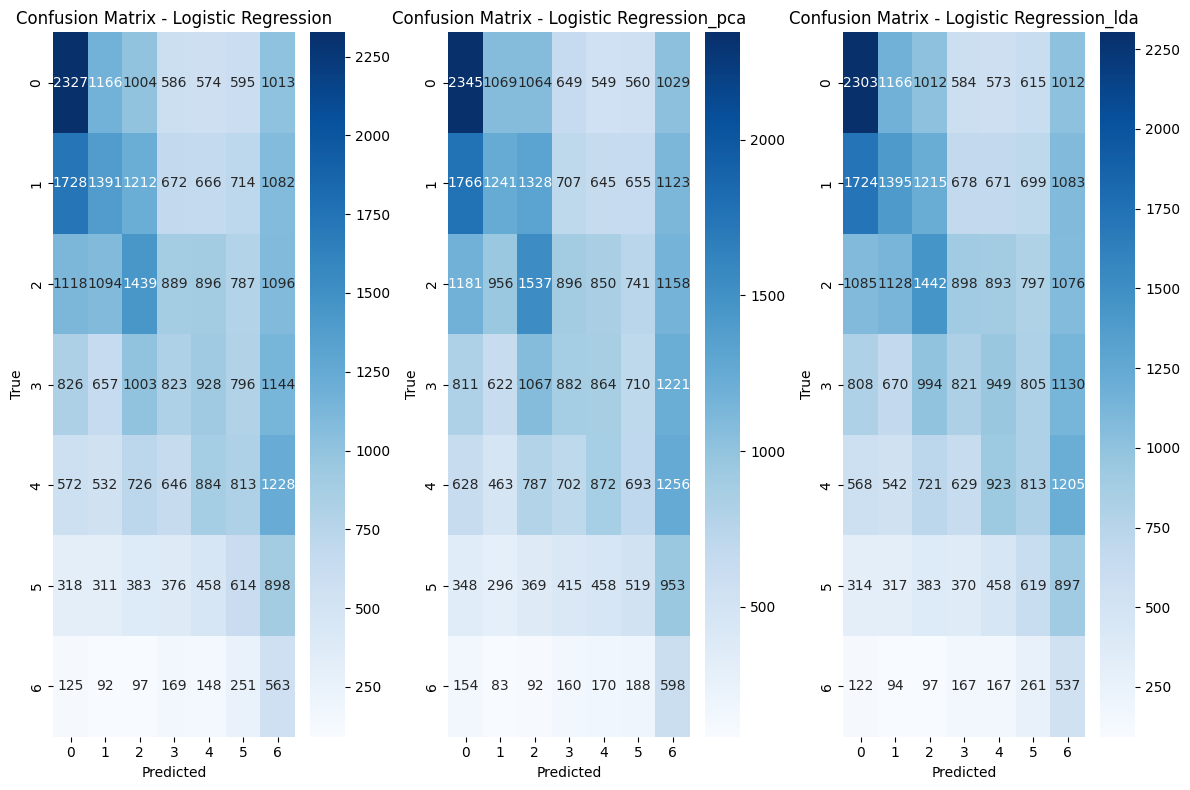

<Figure size 1000x600 with 0 Axes>

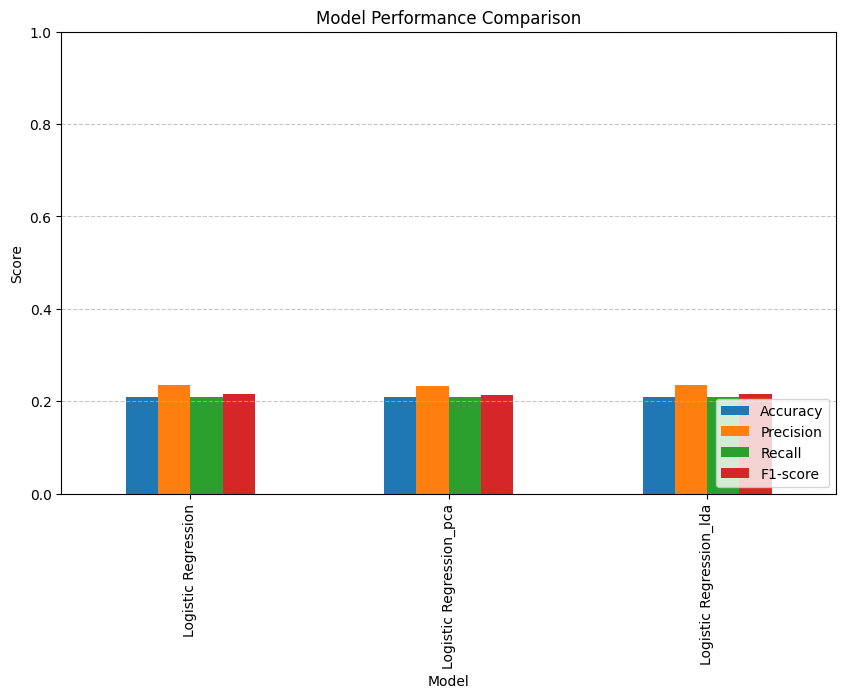

In [32]:
logistic_metrics=fit_pipeline_predict_evaluate(LogisticRegression(solver='lbfgs', max_iter=1000, C=190.0, random_state=27, class_weight="balanced"), "Logistic Regression", PCA=True, LDA=True)

Evaluating Random Forest Classifier on training set...

===== Random Forest Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       1.00      1.00      1.00      4210
        20.0       1.00      1.00      1.00      3842
        30.0       1.00      1.00      1.00      3767
        40.0       1.00      1.00      1.00      3185
        50.0       1.00      1.00      1.00      2780
        60.0       1.00      1.00      1.00      1988
        70.0       1.00      1.00      1.00       854

    accuracy                           1.00     20626
   macro avg       1.00      1.00      1.00     20626
weighted avg       1.00      1.00      1.00     20626


===== Random Forest Classifier_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       1.00      1.00      1.00      4210
        20.0       1.00      1.00      1.00      3842
        30.0       1.00      1.

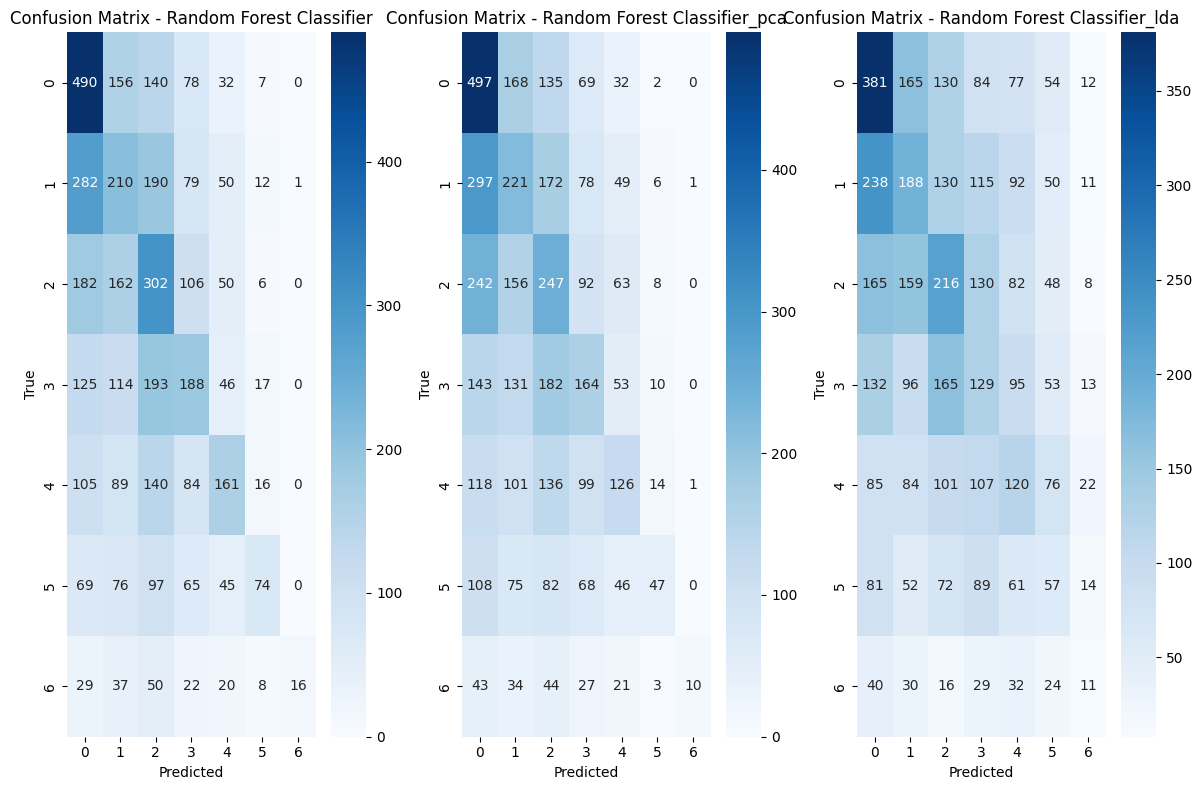

<Figure size 1000x600 with 0 Axes>

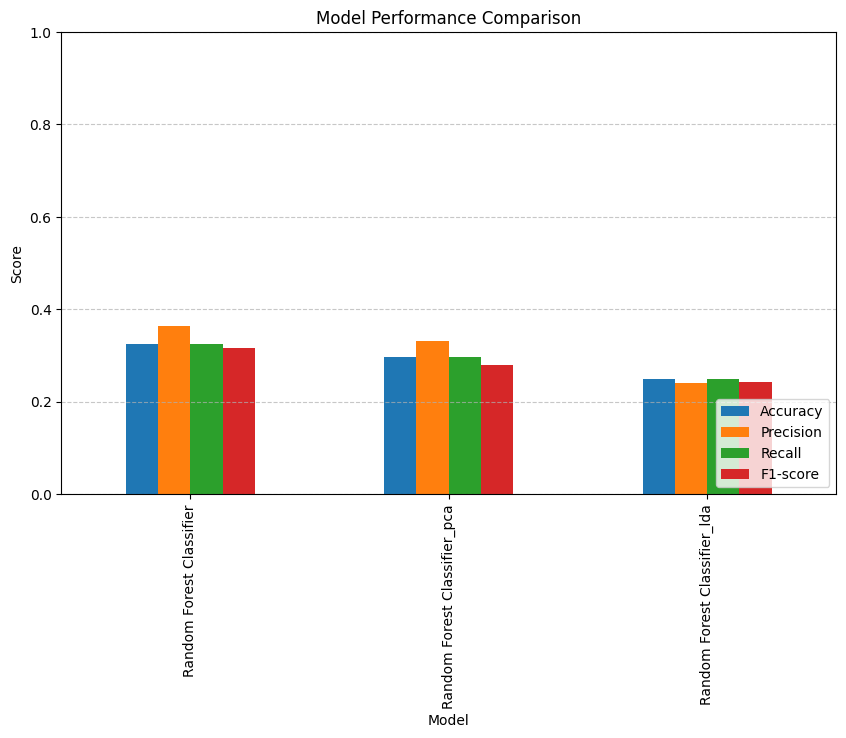

In [173]:
rand_forest_metrics=fit_pipeline_predict_evaluate(RandomForestClassifier(max_depth=20, n_estimators=100, class_weight='balanced')
, "Random Forest Classifier", PCA=True, LDA=True)

Evaluating SVC on training set...

===== SVC: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.32      0.62      0.42      4210
        20.0       0.25      0.20      0.22      3842
        30.0       0.25      0.34      0.29      3767
        40.0       0.24      0.14      0.17      3185
        50.0       0.27      0.22      0.24      2780
        60.0       0.27      0.05      0.08      1988
        70.0       0.12      0.00      0.00       854

    accuracy                           0.28     20626
   macro avg       0.25      0.22      0.20     20626
weighted avg       0.26      0.28      0.25     20626

Evaluating SVC on validation set...

===== SVC: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.32      0.62      0.42       903
        20.0       0.23      0.18      0.20       824
        30.0       0.25      0.33      0.28       808
      

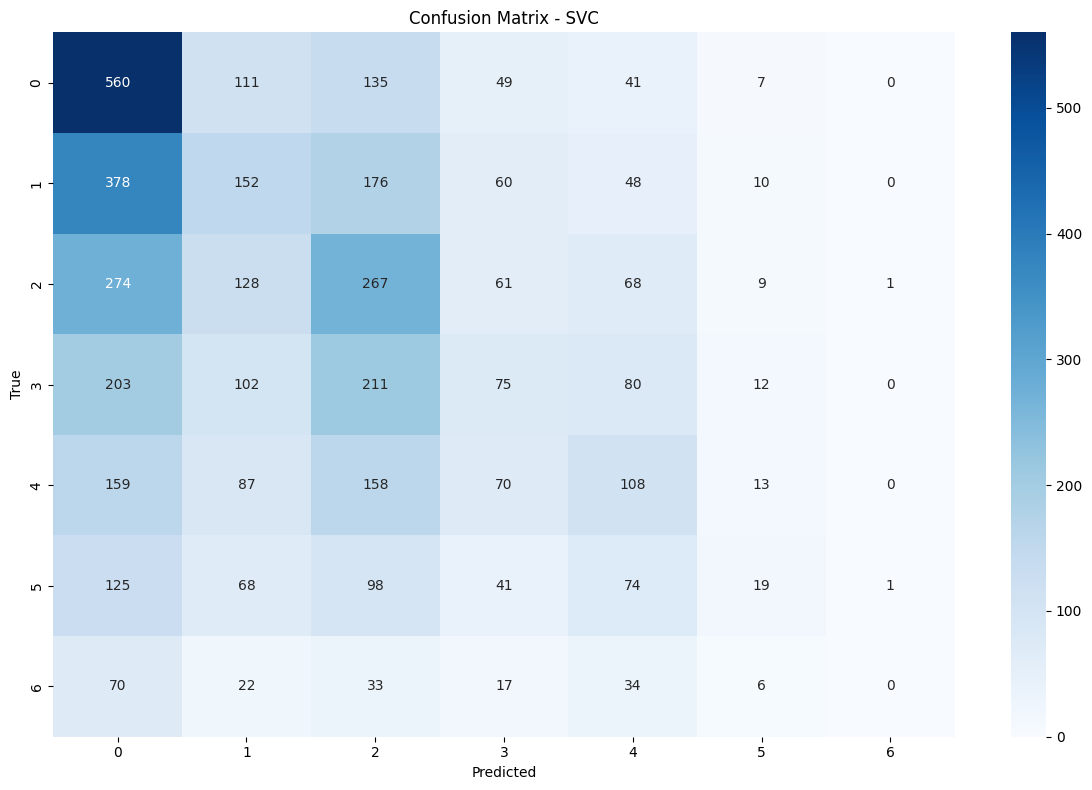

<Figure size 1000x600 with 0 Axes>

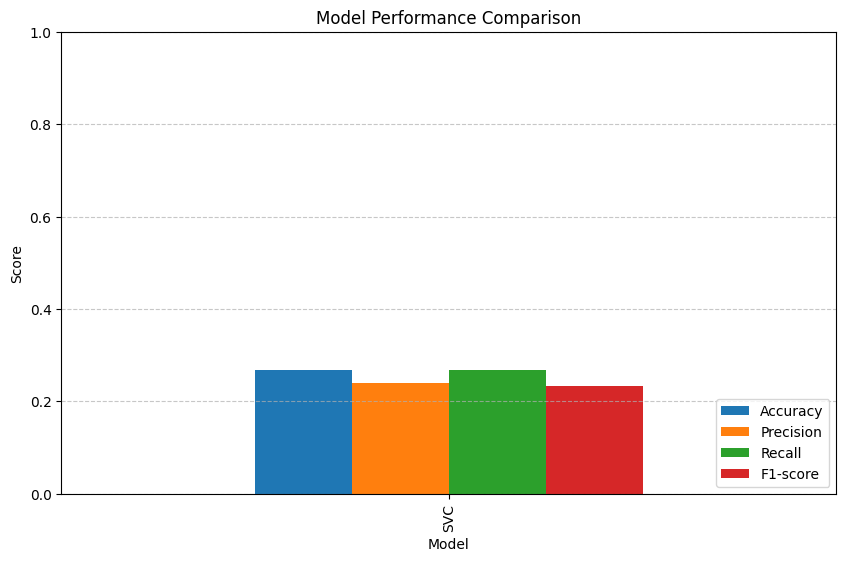

In [174]:
svc_metrics=fit_pipeline_predict_evaluate(LinearSVC(random_state=27, max_iter=1000), "SVC")

Evaluating KNeighbors Classifier on training set...

===== KNeighbors Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.54      0.72      0.62      4210
        20.0       0.50      0.46      0.48      3842
        30.0       0.53      0.52      0.53      3767
        40.0       0.53      0.56      0.55      3185
        50.0       0.60      0.52      0.56      2780
        60.0       0.65      0.51      0.57      1988
        70.0       0.76      0.44      0.56       854

    accuracy                           0.55     20626
   macro avg       0.59      0.53      0.55     20626
weighted avg       0.56      0.55      0.55     20626

Evaluating KNeighbors Classifier on validation set...

===== KNeighbors Classifier: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.41      0.57      0.48       903
        20.0       0.28      0.27      0.2

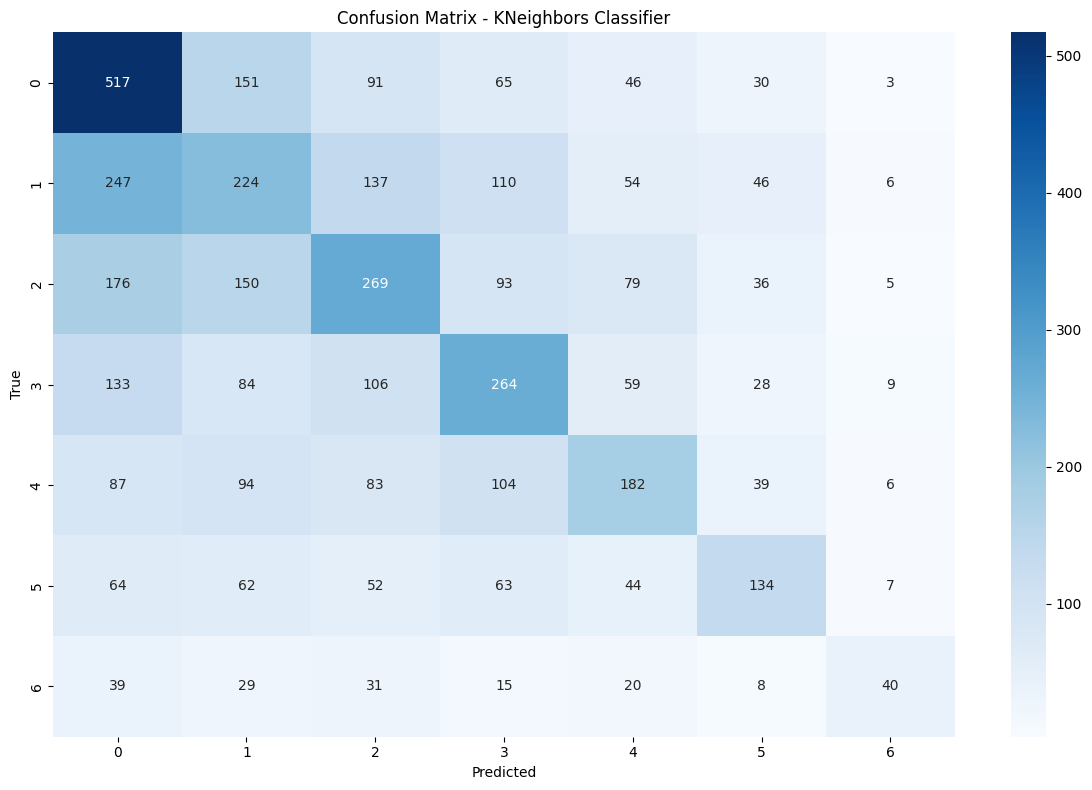

<Figure size 1000x600 with 0 Axes>

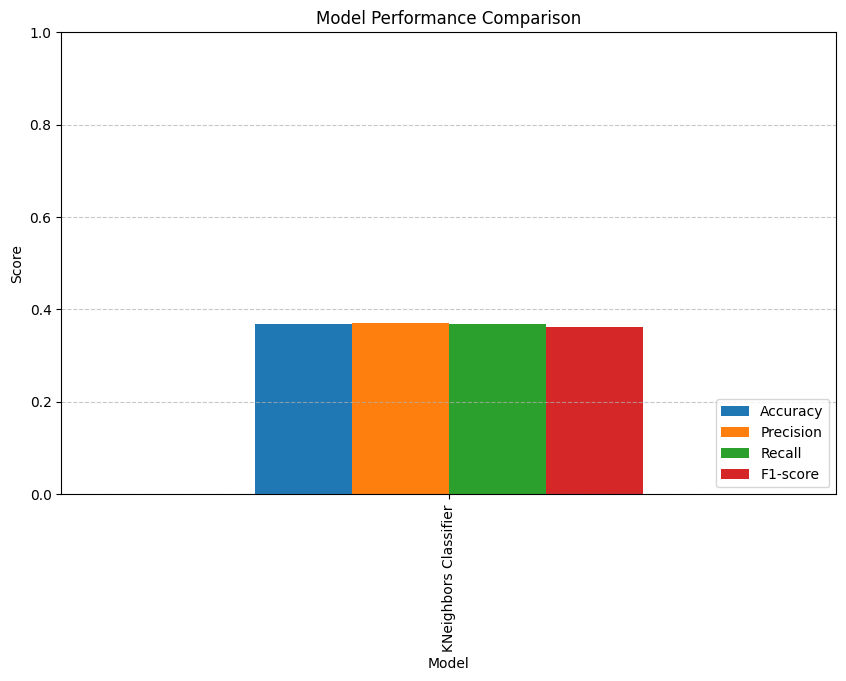

In [175]:
kneighbors_metrics=fit_pipeline_predict_evaluate(KNeighborsClassifier(n_neighbors=10), "KNeighbors Classifier")

In [82]:
# Define base model
model = KNeighborsClassifier()

# Create pipeline with preprocessing
pipeline = make_pipeline(preprocessing, model)

# Define grid of k values (number of neighbors)
param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(1, 21))  # Try k = 1 to 20
}

# Set up GridSearchCV
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

# Run search
search.fit(X_train, y_train['age'])

# Output best parameters
print("Best parameters:", search.best_params_)
print("Best score (accuracy):", search.best_score_)

# Detailed results in a DataFrame
results_df = pd.DataFrame(search.cv_results_).sort_values(by='mean_test_score', ascending=False)
print("\nTop 5 configurations:")
print(results_df[['param_kneighborsclassifier__n_neighbors', 'mean_test_score', 'std_test_score']].head())

print("\nBottom 5 configurations:")
print(results_df[['param_kneighborsclassifier__n_neighbors', 'mean_test_score', 'std_test_score']].tail())


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'kneighborsclassifier__n_neighbors': 14}
Best score (accuracy): 0.22661920624950546

Top 5 configurations:
    param_kneighborsclassifier__n_neighbors  mean_test_score  std_test_score
13                                       14           0.2266          0.0026
16                                       17           0.2250          0.0060
14                                       15           0.2248          0.0049
15                                       16           0.2241          0.0048
17                                       18           0.2237          0.0051

Bottom 5 configurations:
   param_kneighborsclassifier__n_neighbors  mean_test_score  std_test_score
9                                       10           0.2154          0.0017
7                                        8           0.2152          0.0029
2                                        3           0.2117          0.0020
3                     

Evaluating MLP Classifier on training set...

===== MLP Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.43      0.67      0.52      4210
        20.0       0.41      0.32      0.36      3842
        30.0       0.37      0.41      0.39      3767
        40.0       0.42      0.32      0.36      3185
        50.0       0.38      0.41      0.40      2780
        60.0       0.44      0.24      0.31      1988
        70.0       0.53      0.30      0.38       854

    accuracy                           0.41     20626
   macro avg       0.43      0.38      0.39     20626
weighted avg       0.41      0.41      0.40     20626

Evaluating MLP Classifier on validation set...

===== MLP Classifier: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.35      0.57      0.44       903
        20.0       0.22      0.17      0.19       824
        30.0    

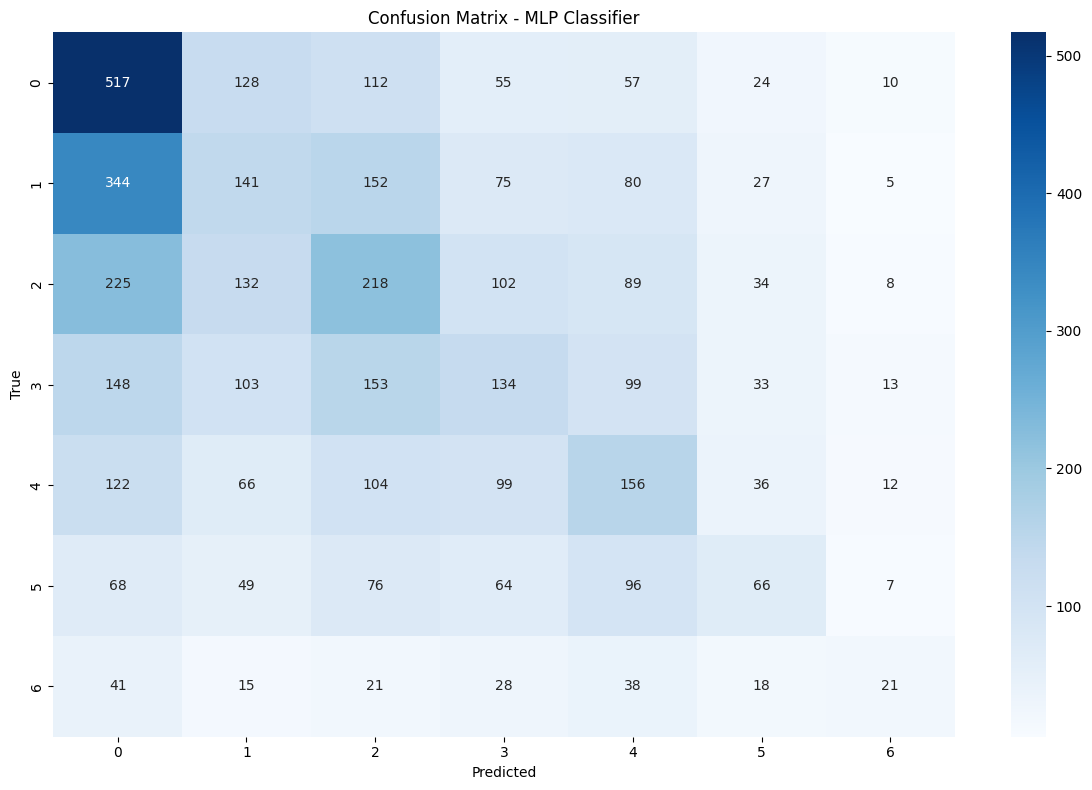

<Figure size 1000x600 with 0 Axes>

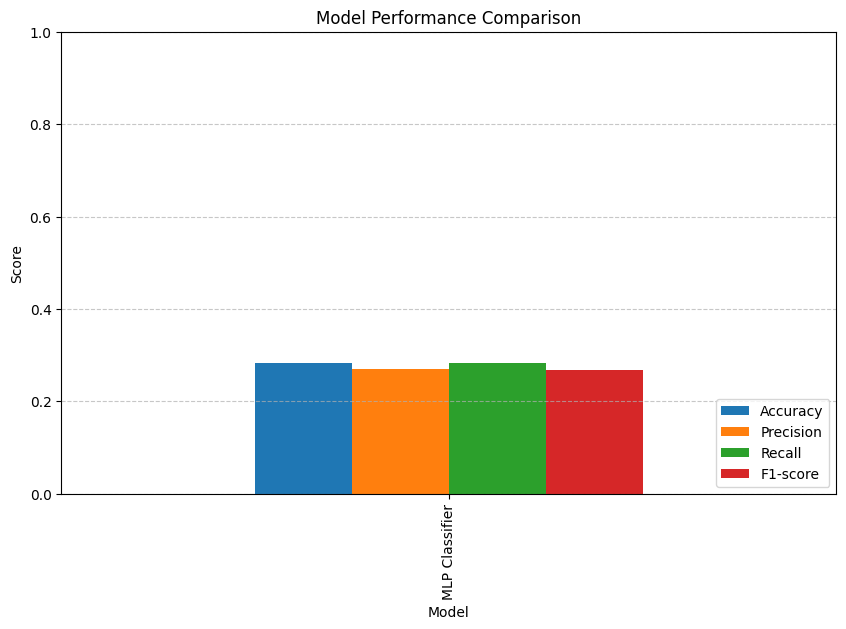

' mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(128, 64, 32),\n              alpha=0.001,\n              learning_rate_init=0.0005,\n              max_iter=2000,\n              batch_size=32,\n              early_stopping=True,\n              validation_fraction=0.1,\n              random_state=27,\n              solver=\'adam\')\n, "MLP Classifier") '

In [176]:
#mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000, random_state=27, batch_size=32, learning_rate='adaptive', learning_rate_init=0.0003), "MLP Classifier")

""" mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(64, 64),
              max_iter=1000,
              random_state=27,
              batch_size=32,
              learning_rate='adaptive',
              learning_rate_init=0.001,
              alpha=0.0001),
 "MLP Classifier") """

""" mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(128, 64),  
              max_iter=1000,
              random_state=27,
              batch_size=64,  
              learning_rate='adaptive',
              learning_rate_init=0.0005,  
              alpha=0.001, 
              early_stopping=True,
              validation_fraction=0.1),
 "MLP Classifier") """


mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(128, 64, 32),
              max_iter=2000,
              random_state=27,
              batch_size=32,
              learning_rate='adaptive',
              learning_rate_init=0.0005,
              alpha=0.001,
              early_stopping=True,
              validation_fraction=0.1)
, "MLP Classifier")

""" mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes=(128, 64, 32),
              alpha=0.001,
              learning_rate_init=0.0005,
              max_iter=2000,
              batch_size=32,
              early_stopping=True,
              validation_fraction=0.1,
              random_state=27,
              solver='adam')
, "MLP Classifier") """

In [34]:
def optimize_mlp_with_gridsearch(param_grid=None, PCA=False, LDA=False):
    if param_grid is None:
        # Updated parameter grid
        param_grid = {
            'mlp__hidden_layer_sizes': [
                (128, 64), 
                (128, 64, 32), 
                (256, 128, 64, 32)
            ],
            'mlp__activation': ['relu', 'tanh', 'logistic'],
            'mlp__alpha': [0.0001, 0.001, 0.01],
            'mlp__learning_rate_init': [0.001, 0.0005, 0.0001],
            'mlp__batch_size': [32, 64],
        }

    mlp = MLPClassifier(
        max_iter=2000,
        random_state=27,
        learning_rate='adaptive',
        early_stopping=True,
        validation_fraction=0.1
    )

    base_pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('mlp', mlp)
    ])

    grid_search = GridSearchCV(
        base_pipeline,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train['age'])

    print(f"Best Parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    prd_train = best_model.predict(X_train)
    prd_val = best_model.predict(X_val)

    if PCA:
        model_pca = MLPClassifier(
            **grid_search.best_params_['mlp'], 
            max_iter=2000, 
            random_state=27, 
            learning_rate='adaptive', 
            early_stopping=True, 
            validation_fraction=0.1
        )
        pipeline_pca = make_pipeline(preprocessing_pca, model_pca)
        pipeline_pca.fit(X_train, y_train['age'])
        prd_train_pca = pipeline_pca.predict(X_train)
        prd_val_pca = pipeline_pca.predict(X_val)

    if LDA:
        model_lda = MLPClassifier(
            **grid_search.best_params_['mlp'], 
            max_iter=2000, 
            random_state=27, 
            learning_rate='adaptive', 
            early_stopping=True, 
            validation_fraction=0.1
        )
        pipeline_lda = make_pipeline(preprocessing_lda, model_lda)
        pipeline_lda.fit(X_train, y_train['age'])
        prd_train_lda = pipeline_lda.predict(X_train)
        prd_val_lda = pipeline_lda.predict(X_val)

    # Build evaluation dicts
    evaluate_train = {'MLP': prd_train}
    evaluate_val = {'MLP': prd_val}

    if PCA:
        evaluate_train['MLP_PCA'] = prd_train_pca
        evaluate_val['MLP_PCA'] = prd_val_pca
    if LDA:
        evaluate_train['MLP_LDA'] = prd_train_lda
        evaluate_val['MLP_LDA'] = prd_val_lda

    print("Evaluating MLP on training set...")
    evaluate_models(y_train['age'], evaluate_train, (12, 8), False, "Training Set")

    print("Evaluating MLP on validation set...")
    return evaluate_models(y_val['age'], evaluate_val, (12, 8), True, "Validation Set")


In [35]:
def optimize_rf_with_gridsearch(param_grid=None, PCA=False, LDA=False):
    
    if param_grid is None:
        param_grid = {
            'rf__n_estimators': [100, 150, 200],
            'rf__max_depth': [None, 10, 20, 30],
            'rf__min_samples_split': [2, 5, 10],
            'rf__min_samples_leaf': [1, 2, 4],
            'rf__bootstrap': [True, False]
        }

    rf = RandomForestClassifier(random_state=27)

    base_pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('rf', rf)
    ])

    grid_search = GridSearchCV(
        base_pipeline,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train['age'])

    print(f"Best Parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    prd_train = best_model.predict(X_train)
    prd_val = best_model.predict(X_val)

    # PCA or LDA variants
    if PCA:
        model_pca = RandomForestClassifier(**grid_search.best_params_['rf'], random_state=27)
        pipeline_pca = make_pipeline(preprocessing_pca, model_pca)
        pipeline_pca.fit(X_train, y_train['age'])
        prd_train_pca = pipeline_pca.predict(X_train)
        prd_val_pca = pipeline_pca.predict(X_val)

    if LDA:
        model_lda = RandomForestClassifier(**grid_search.best_params_['rf'], random_state=27)
        pipeline_lda = make_pipeline(preprocessing_lda, model_lda)
        pipeline_lda.fit(X_train, y_train['age'])
        prd_train_lda = pipeline_lda.predict(X_train)
        prd_val_lda = pipeline_lda.predict(X_val)

    evaluate_train = {'RandomForest': prd_train}
    evaluate_val = {'RandomForest': prd_val}

    if PCA:
        evaluate_train['RandomForest_PCA'] = prd_train_pca
        evaluate_val['RandomForest_PCA'] = prd_val_pca
    if LDA:
        evaluate_train['RandomForest_LDA'] = prd_train_lda
        evaluate_val['RandomForest_LDA'] = prd_val_lda

    print("Evaluating Random Forest on training set...")
    evaluate_models(y_train['age'], evaluate_train, (12, 8), False, "Training Set")

    print("Evaluating Random Forest on validation set...")
    return evaluate_models(y_val['age'], evaluate_val, (12, 8), True, "Validation Set")


In [154]:
# Define base model
model = HistGradientBoostingClassifier(random_state=27)

# Create the pipeline
pipeline = make_pipeline(preprocessing, model)

# Define hyperparameter search space
param_distributions = {
    'histgradientboostingclassifier__max_iter': [300, 500, 700],
    'histgradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1],
    'histgradientboostingclassifier__max_depth': [4, 6, 8, 10],
    'histgradientboostingclassifier__l2_regularization': [0.0, 0.2, 0.5, 1.0],
    'histgradientboostingclassifier__min_samples_leaf': [20, 50, 100]
}

# Set up RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=27,
    n_jobs=-1
)

# Run search
search.fit(X_train, y_train['age'])

# Output best parameters
print("Best parameters:", search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'histgradientboostingclassifier__min_samples_leaf': 20, 'histgradientboostingclassifier__max_iter': 700, 'histgradientboostingclassifier__max_depth': 6, 'histgradientboostingclassifier__learning_rate': 0.05, 'histgradientboostingclassifier__l2_regularization': 0.5}


Evaluating Gradient Boosting Classifier on training set...

===== Gradient Boosting Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.88      0.92      0.90      4210
        20.0       0.90      0.90      0.90      3842
        30.0       0.87      0.90      0.88      3767
        40.0       0.89      0.90      0.90      3185
        50.0       0.93      0.89      0.91      2780
        60.0       0.95      0.88      0.92      1988
        70.0       0.99      0.91      0.95       854

    accuracy                           0.90     20626
   macro avg       0.92      0.90      0.91     20626
weighted avg       0.90      0.90      0.90     20626

Evaluating Gradient Boosting Classifier on validation set...

===== Gradient Boosting Classifier: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.39      0.52      0.45       903
        20.0  

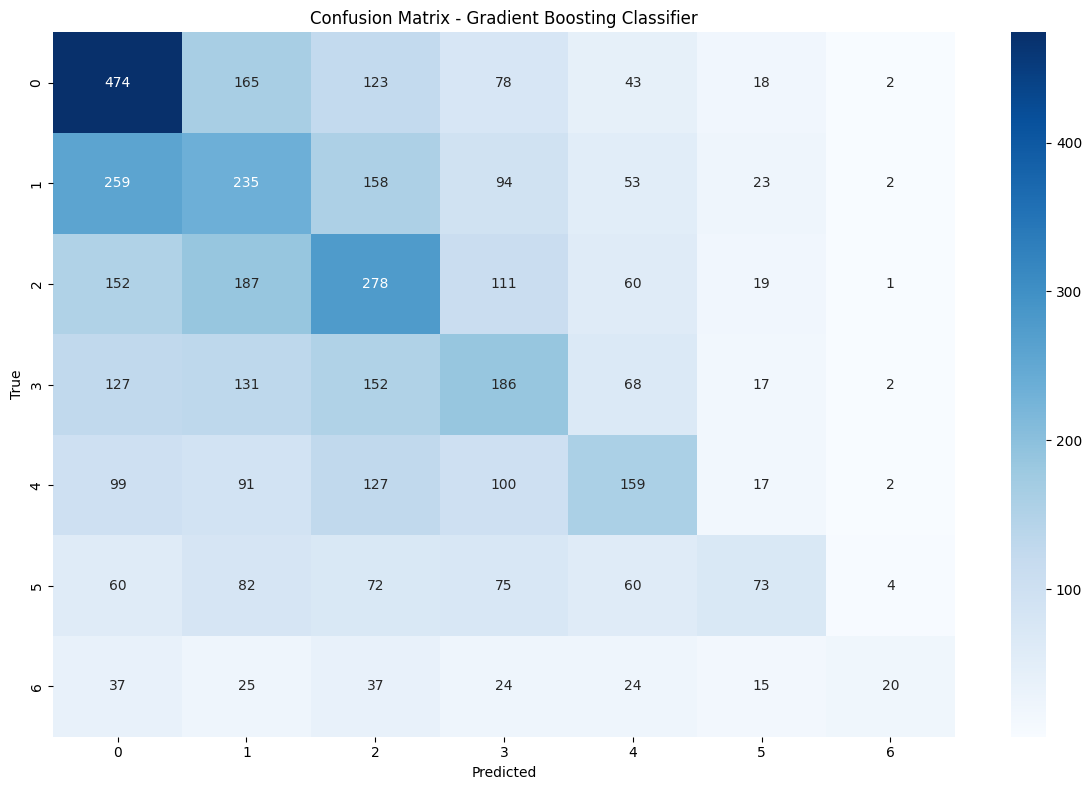

<Figure size 1000x600 with 0 Axes>

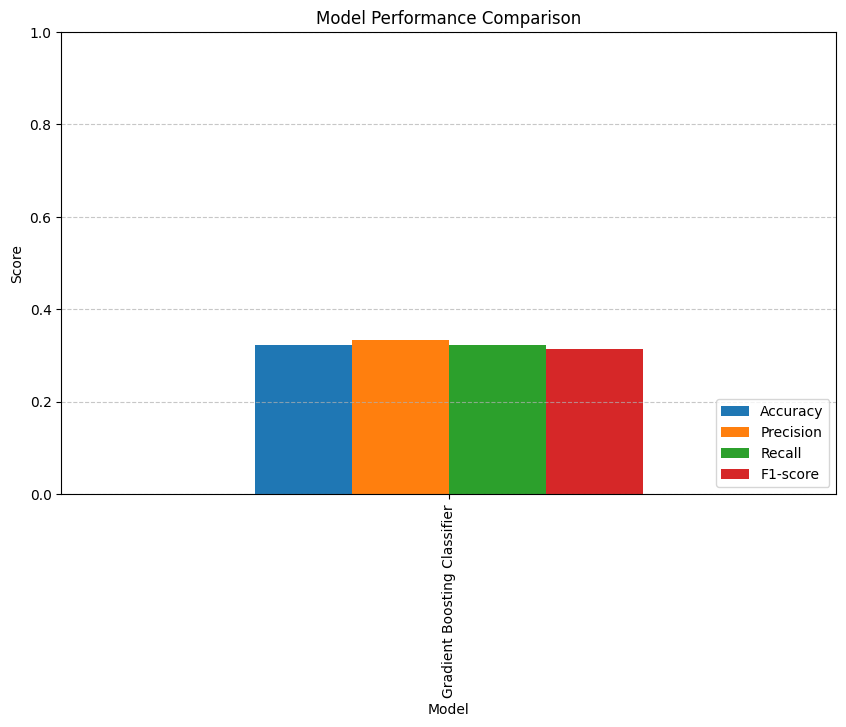

In [177]:
#gradient_boosting_metrics=fit_pipeline_predict_evaluate(HistGradientBoostingClassifier(max_iter=100, random_state=27), "Gradient Boosting Classifier")

gradient_boosting_metrics=fit_pipeline_predict_evaluate(HistGradientBoostingClassifier(
    min_samples_leaf=20,      # Minimum samples per leaf
    max_iter=700,            # Number of boosting rounds
    learning_rate=0.05,      # Learning rate
    max_depth=6,             # Tree depth
    l2_regularization=0.5,   # L2 reg
    random_state=27
), "Gradient Boosting Classifier")

<Figure size 1200x800 with 0 Axes>

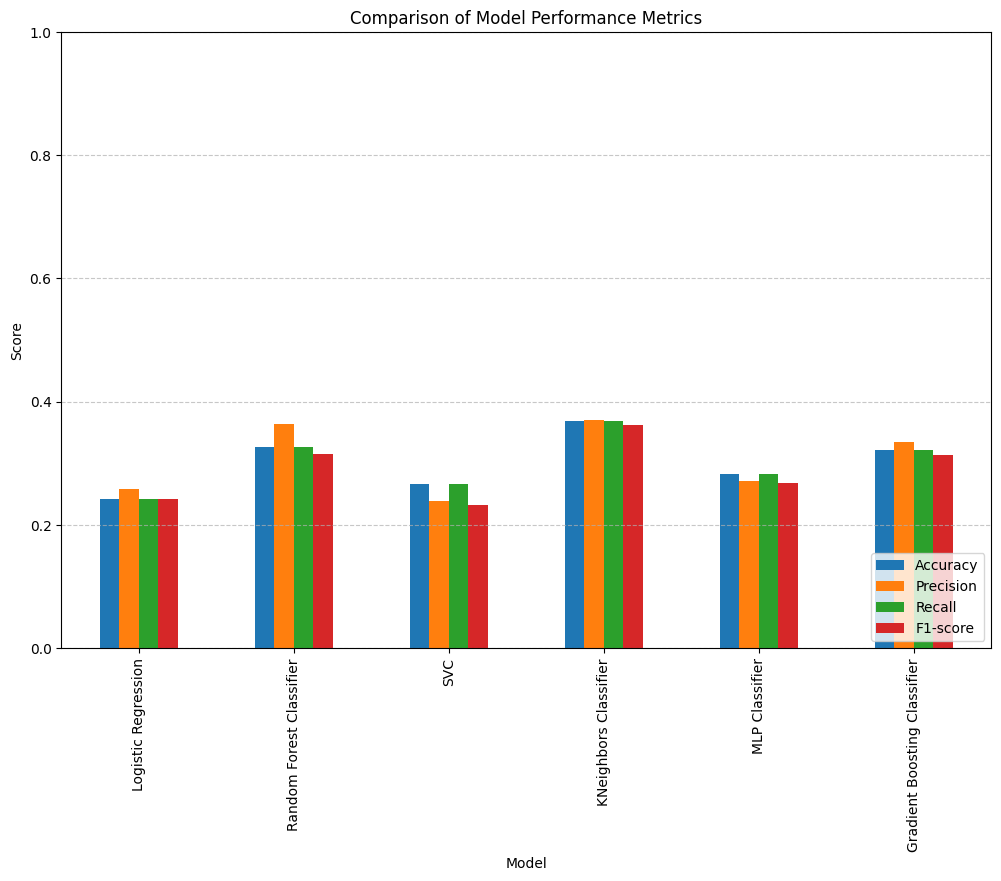

In [178]:
# Compare all metrics in one graph
def compare_all_metrics(logistic_metrics, rand_forest_metrics, svc_metrics, kneighbors_metrics, mlp_metrics, gradient_boosting_metrics):
    # Combine all metrics into a single DataFrame
    combined_metrics = pd.concat([logistic_metrics.set_index('Model'), 
                                   rand_forest_metrics.set_index('Model'), 
                                   svc_metrics.set_index('Model'), 
                                   kneighbors_metrics.set_index('Model'), 
                                   mlp_metrics.set_index('Model'), 
                                   gradient_boosting_metrics.set_index('Model')], axis=0)
    
    # Drop models that end with "pca" or "lda"
    combined_metrics = combined_metrics[~combined_metrics.index.str.endswith(('pca', 'lda'))]
    
    # Plot the combined metrics
    plt.figure(figsize=(12, 8))
    combined_metrics.plot(kind='bar', figsize=(12, 8))
    plt.title('Comparison of Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

compare_all_metrics(logistic_metrics, rand_forest_metrics, svc_metrics, kneighbors_metrics, mlp_metrics, gradient_boosting_metrics)

## Two Stage Models

In [36]:
def evaluate_layered_model(predicted_age_val,y_val, age_model_name, label=None):
    for gender in ['male_masculine', 'female_feminine', 'total']:
        if gender == 'total':
            gender_mask = y_val['gender'].notnull() 
        else:
            gender_mask = y_val['gender'] == gender
            
        y_true_gender = y_val.loc[gender_mask, 'age']
        y_pred_gender = [predicted_age_val[i] for i in range(len(predicted_age_val)) if gender_mask.iloc[i]]

        print(f"\n{age_model_name} -  Age Prediction Report for {gender}: {label}")
        print(classification_report(y_true_gender, y_pred_gender))

        cm_age_gender = confusion_matrix(y_true_gender, y_pred_gender)
        sns.heatmap(cm_age_gender, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Age Prediction for {gender}: {label}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()   

In [37]:
def fit_predict_gender_age_pipeline(gender_model_class, age_model_class_male, age_model_class_female, gender_model_name="GenderModel", age_model_name="AgeModel"):
    """
    Function to fit a gender classification pipeline and then train separate age prediction models by gender.
    Evaluates and visualizes the performance at each stage.
    """
    # Clone models
    gender_model = clone(gender_model_class)
    gender_model_pca = clone(gender_model_class)
    gender_model_lda = clone(gender_model_class)

    # Build gender prediction pipelines
    pipe_gender = make_pipeline(preprocessing, gender_model)
    pipe_gender_pca = make_pipeline(preprocessing_pca, gender_model_pca)
    pipe_gender_lda = make_pipeline(preprocessing_lda, gender_model_lda)

    # Fit gender classifiers
    pipe_gender.fit(X_train, y_train['gender'])
    pipe_gender_pca.fit(X_train, y_train['gender'])
    pipe_gender_lda.fit(X_train, y_train['gender'])

    # Evaluate gender predictions
    for name, pipe in zip(['Default', 'PCA', 'LDA'], [pipe_gender, pipe_gender_pca, pipe_gender_lda]):
        for split_name, X, y in [('Training', X_train, y_train), ('Validation', X_val, y_val)]:
            preds = pipe.predict(X)
            print(f"\n{name} Gender Model - {split_name} Set:")
            print(classification_report(y['gender'], preds))

            if split_name == 'Validation':
                cm = confusion_matrix(y['gender'], preds)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix - Gender ({name}, {split_name} Set)')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.show()

    # Use the default pipeline for gender predictions
    predicted_gender_val = pipe_gender.predict(X_val)

    # Train separate age models on true gender-labeled training data
    X_train_male = X_train[y_train['gender'] == 'male_masculine']
    y_train_male = y_train.loc[y_train['gender'] == 'male_masculine', 'age']
    X_train_female = X_train[y_train['gender'] == 'female_feminine']
    y_train_female = y_train.loc[y_train['gender'] == 'female_feminine', 'age']

    pipe_age_male = make_pipeline(preprocessing, clone(age_model_class_male))
    pipe_age_female = make_pipeline(preprocessing, clone(age_model_class_female))

    pipe_age_male.fit(X_train_male, y_train_male)
    pipe_age_female.fit(X_train_female, y_train_female)

    # Predict age on validation set using predicted gender
    predicted_age_val = []
    for i, gender in enumerate(predicted_gender_val):
        x_instance = X_val.iloc[[i]]  # preserve column names
        if gender == 'male_masculine':
            predicted_age_val.append(pipe_age_male.predict(x_instance)[0])
        else:
            predicted_age_val.append(pipe_age_female.predict(x_instance)[0])
    
    evaluate_layered_model(predicted_age_val, y_val, age_model_name, "Validation Set")


In [38]:
def fit_predict_gender_age_pipeline_with_joint_comparison(
    gender_model_class,
    age_model_class_male,
    age_model_class_female,
    gender_model_name="GenderModel",
    age_model_name="AgeModel"):

    # ====== Build models ======
    gender_model = clone(gender_model_class)
    
    # ====== Fit gender model ======
    pipe_gender = make_pipeline(preprocessing, gender_model)
    pipe_gender.fit(X_train, y_train['gender'])

    predicted_gender_train=pipe_gender.predict(X_train)
    predicted_gender_val = pipe_gender.predict(X_val)
    for split_name, preds, y in [('Training', predicted_gender_train, y_train), ('Validation', predicted_gender_val, y_val)]:
            print(f"\n{gender_model_name} Gender Model - {split_name} Set:")
            print(classification_report(y['gender'], preds))

            if split_name == 'Validation':
                cm = confusion_matrix(y['gender'], preds)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix - Gender ({gender_model_name}, {split_name} Set)')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.show()

    # ====== Train age models ======
    # Split train set by gender
    X_train_male = X_train[y_train['gender'] == 'male_masculine']
    y_train_male = y_train.loc[y_train['gender'] == 'male_masculine', 'age']
    X_train_female = X_train[y_train['gender'] == 'female_feminine']
    y_train_female = y_train.loc[y_train['gender'] == 'female_feminine', 'age']

    # Fit individual age models
    
    pipe_age_male = make_pipeline(preprocessing, clone(age_model_class_male))
    pipe_age_female = make_pipeline(preprocessing, clone(age_model_class_female))

    print(f"\nFitting {age_model_name} male")
    pipe_age_male.fit(X_train_male, y_train_male)
    print(f"\nFitting {age_model_name} female")
    pipe_age_female.fit(X_train_female, y_train_female)
    
    # ====== Age predictions ======
    predicted_age_true_gender = []
    predicted_age_pred_gender = []
    for i in tqdm(range(len(X_val)), desc=f"Predicting {age_model_name} on validation set"):
        x_instance = X_val.iloc[[i]]

        # TRUE gender routing
        true_gender = y_val.iloc[i]['gender']
        model_true = pipe_age_male if true_gender == 'male_masculine' else pipe_age_female
        predicted_age_true_gender.append(model_true.predict(x_instance)[0])

        # PREDICTED gender routing
        pred_gender = predicted_gender_val[i]
        model_pred = pipe_age_male if pred_gender == 'male_masculine' else pipe_age_female
        predicted_age_pred_gender.append(model_pred.predict(x_instance)[0])

    # ====== Evaluation ======

    evaluate_layered_model(predicted_age_true_gender, y_val, age_model_name, "Routed by True Gender")
    evaluate_layered_model(predicted_age_pred_gender, y_val, age_model_name, "Routed by Predicted Gender")

    # ====== Routing error cost ======
    acc_true = accuracy_score(y_val['age'], predicted_age_true_gender)
    acc_pred = accuracy_score(y_val['age'], predicted_age_pred_gender)
    routing_cost = acc_true - acc_pred
    print(f"\n🔍 Routing Error Cost (Accuracy Loss from using predicted gender): {routing_cost:.4f}")

    return {
        "acc_true_gender": acc_true,
        "acc_pred_gender": acc_pred,
        "routing_error_cost": routing_cost
    }


In [60]:
# Grid search to tune age prediciton on true gender

X_train_male = X_train[y_train['gender'] == 'male_masculine']
y_train_male = y_train[y_train['gender'] == 'male_masculine']
X_val_male = X_val[y_val['gender'] == 'male_masculine']
y_val_male = y_val[y_val['gender'] == 'male_masculine']

X_train_female = X_train[y_train['gender'] == 'female_feminine']
y_train_female = y_train[y_train['gender'] == 'female_feminine']
X_val_female = X_val[y_val['gender'] == 'female_feminine']
y_val_female = y_val[y_val['gender'] == 'female_feminine']




def optimize_mlp_for_gender(
    X_train, y_train, X_val, y_val,
    preprocessing,
    param_grid=None
):
    if param_grid is None:
        param_grid = {
            'mlp__hidden_layer_sizes': [(128, 64, 32), (256, 128, 64, 32)],
            'mlp__activation': ['relu', 'tanh'],
            'mlp__alpha': [0.0001, 0.001, 0.01],
            'mlp__learning_rate_init': [0.001, 0.0005, 0.0001],
            'mlp__batch_size': [32, 64],
        }

    mlp = MLPClassifier(
        max_iter=2000,
        random_state=27,
        learning_rate='adaptive',
        early_stopping=True,
        validation_fraction=0.1
    )

    pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('mlp', mlp)
    ])

    # Create stratification labels from age and gender
    strat_labels = y_train['age'].astype(str) + "-" + y_train['gender']
    # Define stratified k-fold cross-validation on full training set
    stratified_cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=27).split(X_train, strat_labels)

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=stratified_cv,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    print("Starting grid search for MLP...")
    grid_search.fit(X_train, y_train["age"])

    print(f"\nBest Parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    # Detailed results as DataFrame
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)
    print("\nTop 5 configurations:")
    display_cols = [col for col in results_df.columns if col.startswith("param_")]
    display_cols += ['mean_test_score', 'std_test_score']
    print(results_df_sorted[display_cols].head())

    # Predictions
    prd_train = best_model.predict(X_train)
    prd_val = best_model.predict(X_val)

    # Evaluation
    evaluate_train = {'MLP': prd_train}
    evaluate_val = {'MLP': prd_val}

    print("\nEvaluating MLP on training set...")
    evaluate_models(y_train["age"], evaluate_train, (12, 8), False, "Training Set")

    print("\nEvaluating MLP on validation set...")
    evaluate_models(y_val["age"], evaluate_val, (12, 8), True, "Validation Set")

    return best_model, evaluate_train, evaluate_val, results_df_sorted


Starting grid search for MLP...
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.0005; total time=   8.0s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.001; total time=   8.3s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.0005; total time=   9.1s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.0001; total time=  13.9s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.0005; total time=  15.4s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.0001; total time=  17.8s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size

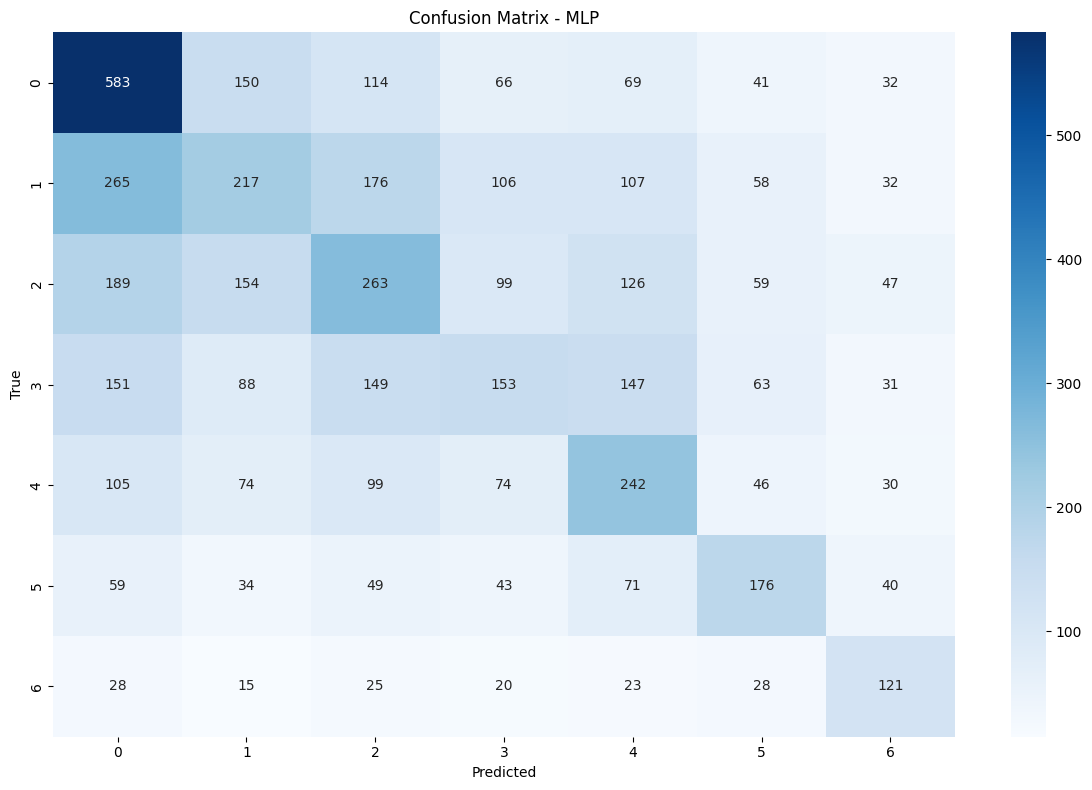

<Figure size 1000x600 with 0 Axes>

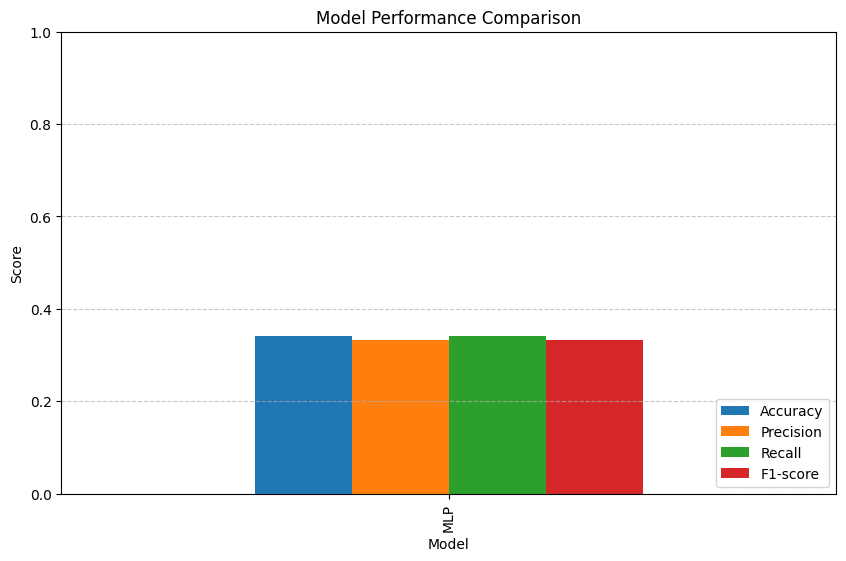

ValueError: too many values to unpack (expected 3)

In [ ]:
best_male_model, train_eval_male, val_eval_male, results_male = optimize_mlp_for_gender(
    X_train_male, y_train_male, X_val_male, y_val_male, preprocessing=preprocessing
)

Starting grid search for MLP...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=  14.3s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.0005; total time=  19.1s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.0001; total time=  19.1s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=  19.2s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.0001; total time=  21.5s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=32, mlp__hidden_layer_sizes=(128, 64, 32),

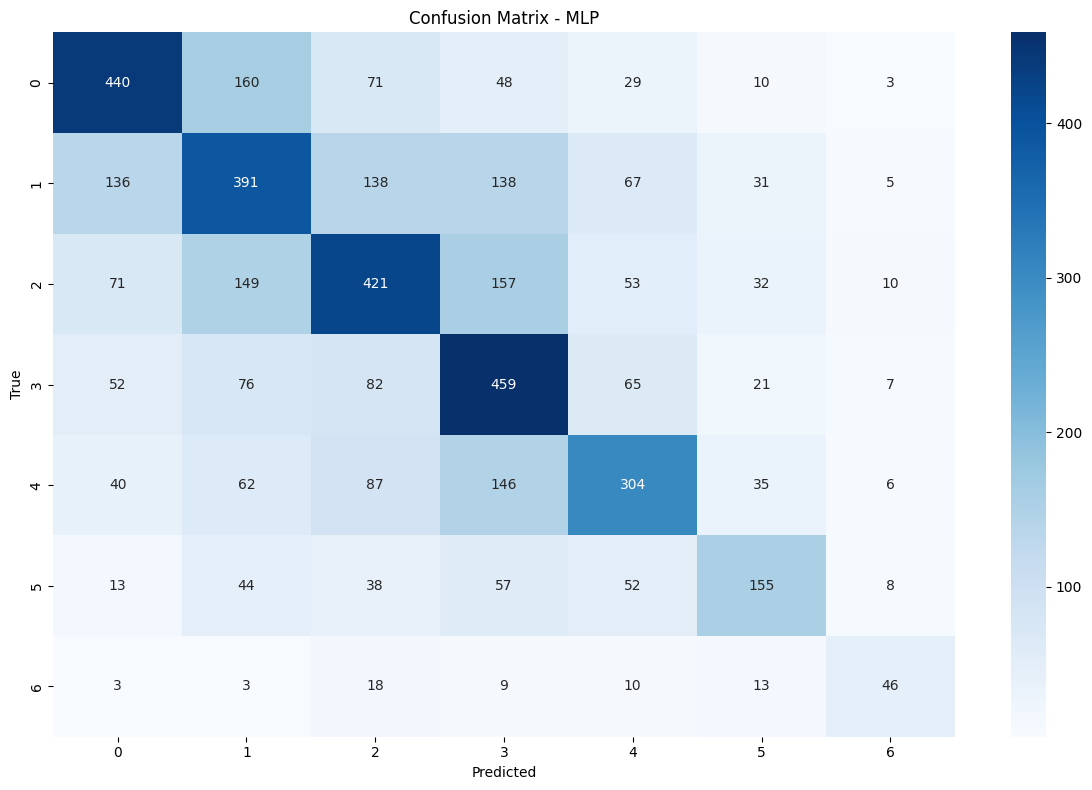

<Figure size 1000x600 with 0 Axes>

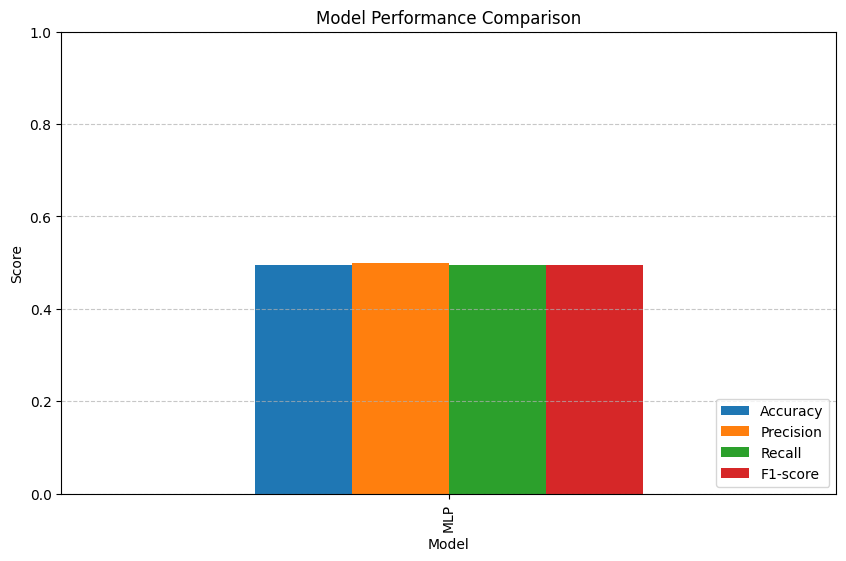

In [61]:
best_female_model, train_eval_female, val_eval_female, results_female = optimize_mlp_for_gender(
    X_train_female, y_train_female, X_val_female, y_val_female, preprocessing=preprocessing
)


LogisticRegression Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.87      0.86      0.86     18413
 male_masculine       0.88      0.89      0.88     21147

       accuracy                           0.87     39560
      macro avg       0.87      0.87      0.87     39560
   weighted avg       0.87      0.87      0.87     39560


LogisticRegression Gender Model - Validation Set:
                 precision    recall  f1-score   support

female_feminine       0.87      0.86      0.87      3946
 male_masculine       0.88      0.89      0.88      4532

       accuracy                           0.88      8478
      macro avg       0.87      0.87      0.87      8478
   weighted avg       0.88      0.88      0.88      8478



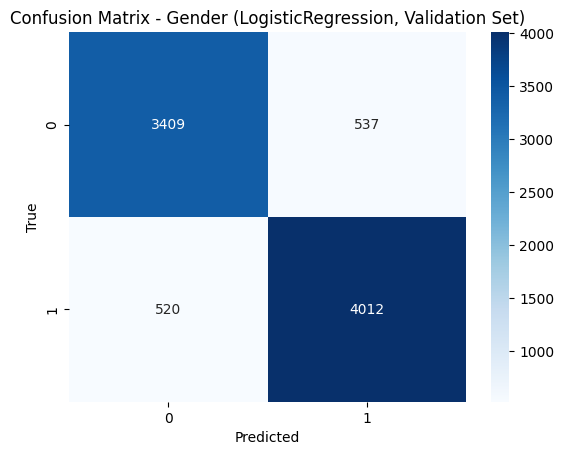


Fitting KNN_by_gender male

Fitting KNN_by_gender female


Predicting KNN_by_gender on validation set: 100%|██████████| 8478/8478 [02:06<00:00, 67.22it/s]



KNN_by_gender -  Age Prediction Report for male_masculine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.37      0.44      0.40       931
        20.0       0.26      0.27      0.27       848
        30.0       0.27      0.31      0.29       827
        40.0       0.31      0.31      0.31       690
        50.0       0.32      0.27      0.30       591
        60.0       0.41      0.27      0.33       416
        70.0       0.43      0.26      0.32       229

    accuracy                           0.32      4532
   macro avg       0.34      0.31      0.32      4532
weighted avg       0.32      0.32      0.32      4532



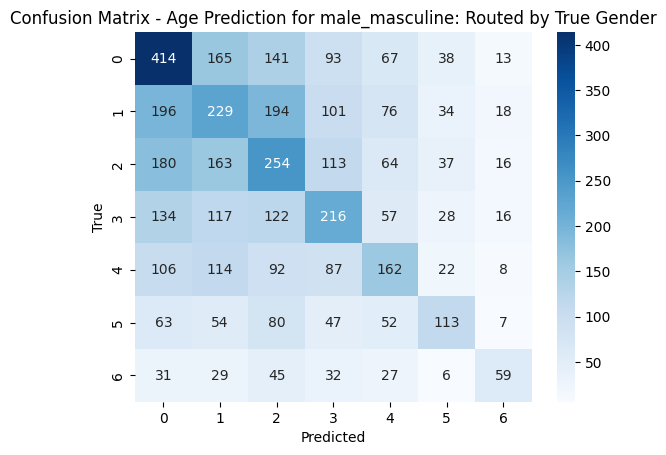


KNN_by_gender -  Age Prediction Report for female_feminine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.58      0.70      0.63       671
        20.0       0.48      0.43      0.45       800
        30.0       0.53      0.56      0.54       788
        40.0       0.58      0.62      0.60       673
        50.0       0.61      0.54      0.57       600
        60.0       0.69      0.56      0.62       324
        70.0       0.68      0.53      0.60        90

    accuracy                           0.56      3946
   macro avg       0.59      0.56      0.57      3946
weighted avg       0.56      0.56      0.56      3946



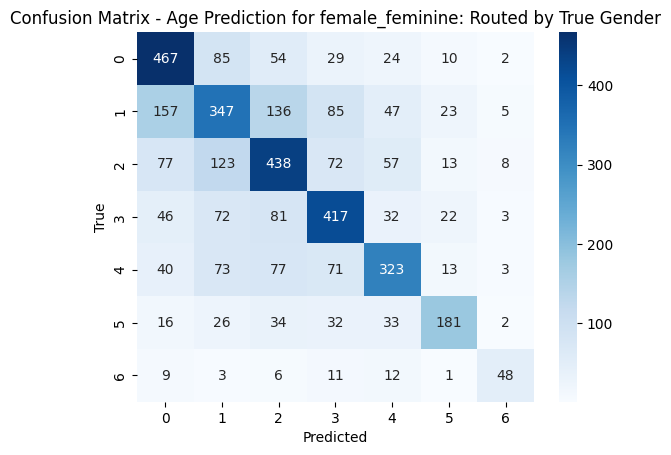


KNN_by_gender -  Age Prediction Report for total: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.46      0.55      0.50      1602
        20.0       0.36      0.35      0.35      1648
        30.0       0.39      0.43      0.41      1615
        40.0       0.45      0.46      0.46      1363
        50.0       0.47      0.41      0.44      1191
        60.0       0.54      0.40      0.46       740
        70.0       0.51      0.34      0.41       319

    accuracy                           0.43      8478
   macro avg       0.46      0.42      0.43      8478
weighted avg       0.44      0.43      0.43      8478



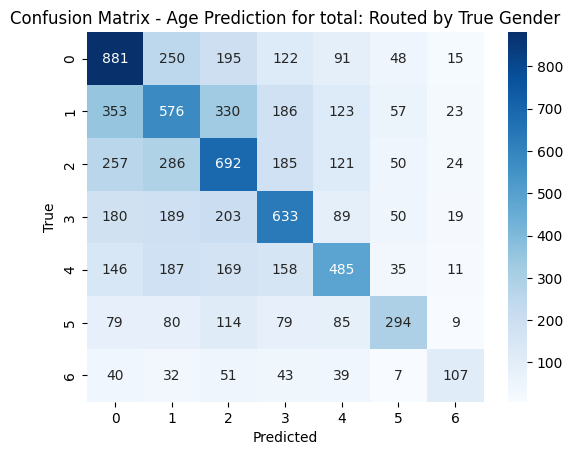


KNN_by_gender -  Age Prediction Report for male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.34      0.38      0.36       931
        20.0       0.25      0.25      0.25       848
        30.0       0.27      0.30      0.28       827
        40.0       0.29      0.31      0.30       690
        50.0       0.29      0.27      0.28       591
        60.0       0.38      0.25      0.30       416
        70.0       0.42      0.24      0.30       229

    accuracy                           0.30      4532
   macro avg       0.32      0.29      0.30      4532
weighted avg       0.30      0.30      0.30      4532



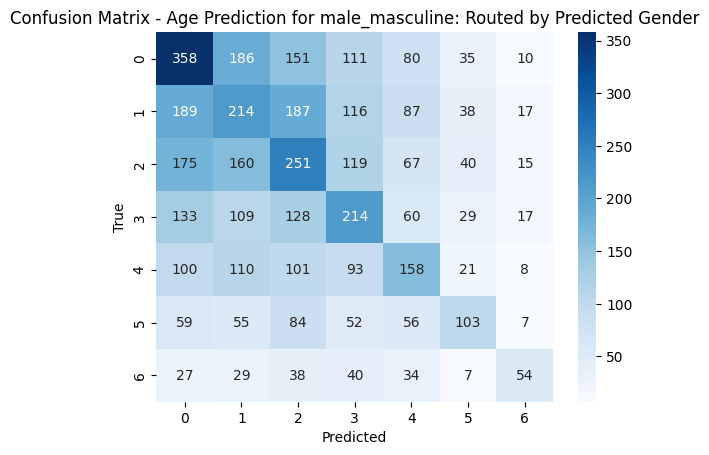


KNN_by_gender -  Age Prediction Report for female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.49      0.65      0.55       671
        20.0       0.43      0.41      0.42       800
        30.0       0.48      0.50      0.49       788
        40.0       0.53      0.55      0.54       673
        50.0       0.57      0.45      0.50       600
        60.0       0.64      0.47      0.54       324
        70.0       0.53      0.42      0.47        90

    accuracy                           0.50      3946
   macro avg       0.52      0.49      0.50      3946
weighted avg       0.51      0.50      0.50      3946



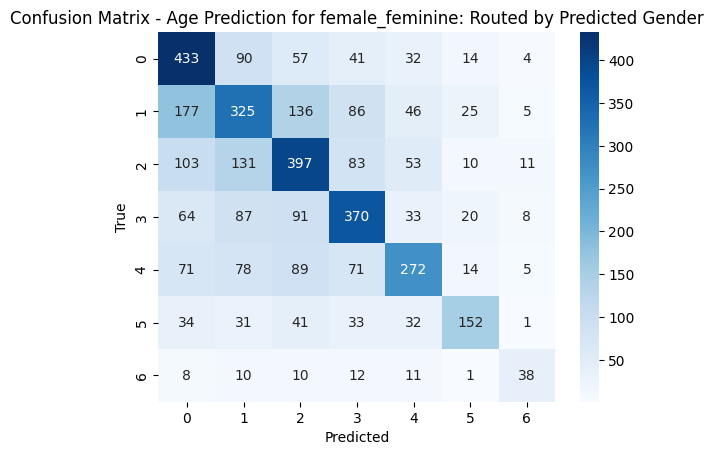


KNN_by_gender -  Age Prediction Report for total: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.41      0.49      0.45      1602
        20.0       0.33      0.33      0.33      1648
        30.0       0.37      0.40      0.38      1615
        40.0       0.41      0.43      0.42      1363
        50.0       0.42      0.36      0.39      1191
        60.0       0.50      0.34      0.41       740
        70.0       0.46      0.29      0.35       319

    accuracy                           0.39      8478
   macro avg       0.41      0.38      0.39      8478
weighted avg       0.40      0.39      0.39      8478



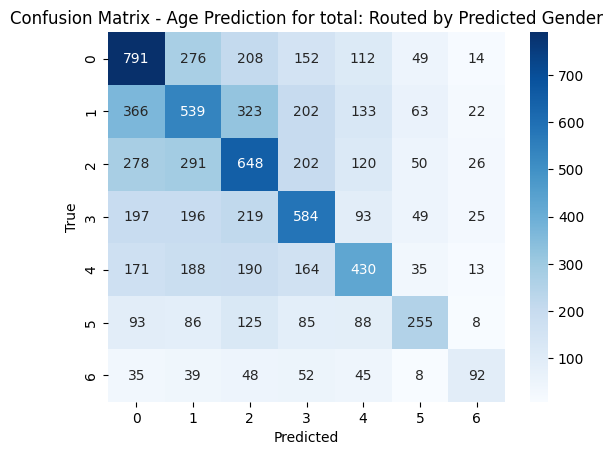


🔍 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0388


{'acc_true_gender': 0.4326492097192734,
 'acc_pred_gender': 0.39384288747346075,
 'routing_error_cost': 0.03880632224581265}

In [157]:
""" fit_predict_gender_age_pipeline(
    gender_model_class=LogisticRegression(max_iter=1000),
    age_model_class_male=KNeighborsClassifier(n_neighbors=5),
    age_model_class_female=KNeighborsClassifier(n_neighbors=5),
    gender_model_name="LogisticRegression",
    age_model_name="KNN_by_gender"
) """

fit_predict_gender_age_pipeline_with_joint_comparison(
    gender_model_class=LogisticRegression(max_iter=1000),
    age_model_class_male=KNeighborsClassifier(n_neighbors=5),
    age_model_class_female=KNeighborsClassifier(n_neighbors=5),
    gender_model_name="LogisticRegression",
    age_model_name="KNN_by_gender"
)



KNN_by_age Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.89      0.83      0.86      4421
 male_masculine       0.89      0.93      0.91      6293

       accuracy                           0.89     10714
      macro avg       0.89      0.88      0.88     10714
   weighted avg       0.89      0.89      0.89     10714


KNN_by_age Gender Model - Validation Set:
                 precision    recall  f1-score   support

female_feminine       0.82      0.74      0.78       947
 male_masculine       0.83      0.88      0.86      1349

       accuracy                           0.82      2296
      macro avg       0.82      0.81      0.82      2296
   weighted avg       0.82      0.82      0.82      2296



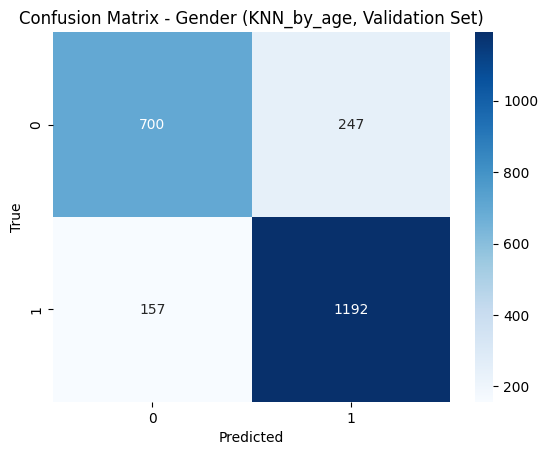


Fitting KNN_by_gender male

Fitting KNN_by_gender female


Predicting KNN_by_gender on validation set: 100%|██████████| 2296/2296 [00:32<00:00, 71.05it/s]



KNN_by_gender -  Age Prediction Report for male_masculine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.23      0.31      0.27       279
        20.0       0.24      0.26      0.25       255
        30.0       0.22      0.24      0.23       248
        40.0       0.19      0.22      0.20       207
        50.0       0.12      0.10      0.11       178
        60.0       0.05      0.02      0.03       125
        70.0       0.00      0.00      0.00        57

    accuracy                           0.21      1349
   macro avg       0.15      0.16      0.16      1349
weighted avg       0.19      0.21      0.19      1349



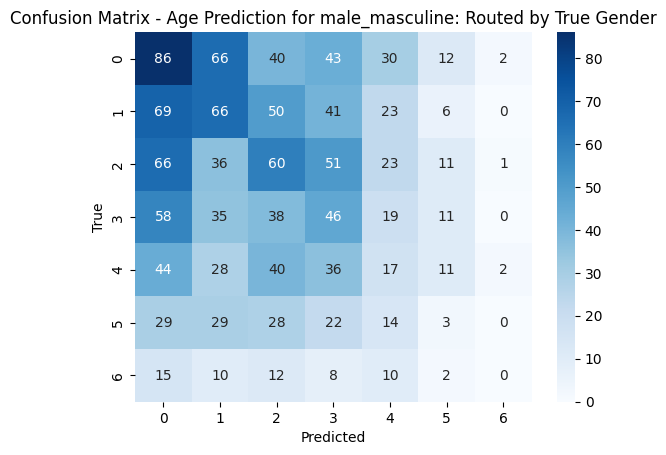


KNN_by_gender -  Age Prediction Report for female_feminine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.25      0.34      0.29       139
        20.0       0.28      0.32      0.30       239
        30.0       0.35      0.39      0.37       214
        40.0       0.17      0.15      0.16       137
        50.0       0.17      0.11      0.14       133
        60.0       0.26      0.12      0.16        66
        70.0       0.00      0.00      0.00        19

    accuracy                           0.27       947
   macro avg       0.21      0.21      0.20       947
weighted avg       0.25      0.27      0.26       947



c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

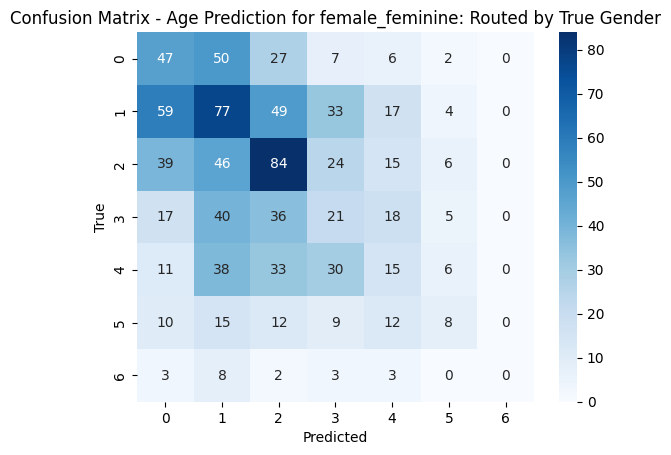


KNN_by_gender -  Age Prediction Report for total: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.24      0.32      0.27       418
        20.0       0.26      0.29      0.28       494
        30.0       0.28      0.31      0.30       462
        40.0       0.18      0.19      0.19       344
        50.0       0.14      0.10      0.12       311
        60.0       0.13      0.06      0.08       191
        70.0       0.00      0.00      0.00        76

    accuracy                           0.23      2296
   macro avg       0.18      0.18      0.18      2296
weighted avg       0.21      0.23      0.22      2296



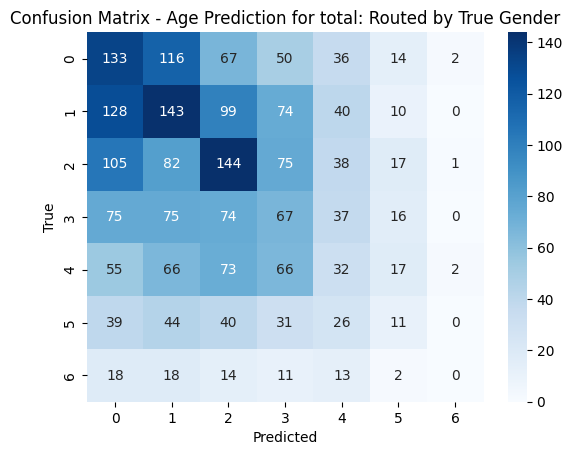


KNN_by_gender -  Age Prediction Report for male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.25      0.31      0.28       279
        20.0       0.24      0.27      0.25       255
        30.0       0.22      0.24      0.23       248
        40.0       0.18      0.22      0.20       207
        50.0       0.13      0.11      0.12       178
        60.0       0.04      0.02      0.02       125
        70.0       0.00      0.00      0.00        57

    accuracy                           0.21      1349
   macro avg       0.15      0.17      0.16      1349
weighted avg       0.19      0.21      0.19      1349



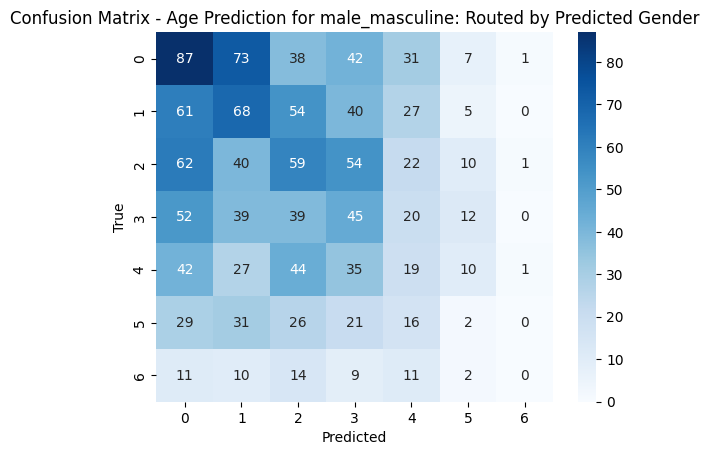


KNN_by_gender -  Age Prediction Report for female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.21      0.34      0.26       139
        20.0       0.28      0.31      0.29       239
        30.0       0.33      0.35      0.34       214
        40.0       0.15      0.14      0.14       137
        50.0       0.15      0.08      0.10       133
        60.0       0.16      0.08      0.10        66
        70.0       0.00      0.00      0.00        19

    accuracy                           0.24       947
   macro avg       0.18      0.18      0.18       947
weighted avg       0.23      0.24      0.23       947



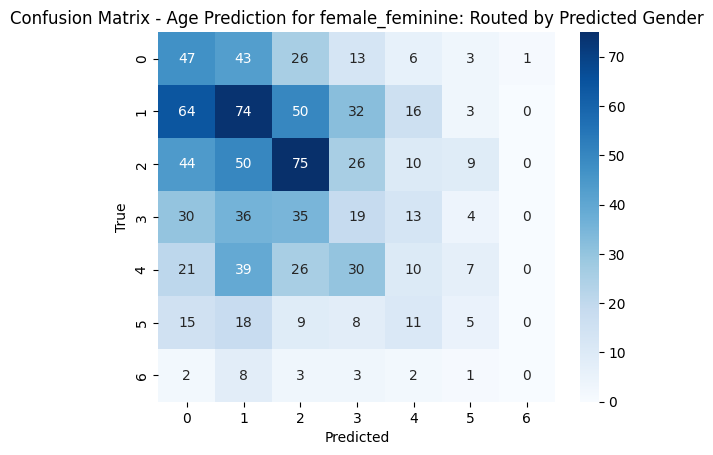


KNN_by_gender -  Age Prediction Report for total: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.24      0.32      0.27       418
        20.0       0.26      0.29      0.27       494
        30.0       0.27      0.29      0.28       462
        40.0       0.17      0.19      0.18       344
        50.0       0.14      0.09      0.11       311
        60.0       0.09      0.04      0.05       191
        70.0       0.00      0.00      0.00        76

    accuracy                           0.22      2296
   macro avg       0.16      0.17      0.17      2296
weighted avg       0.20      0.22      0.21      2296



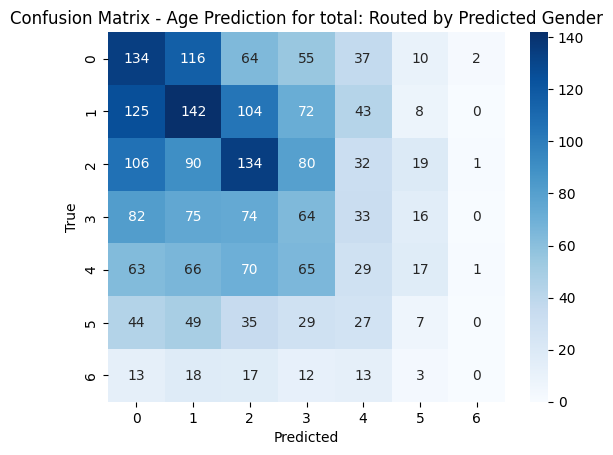


🔍 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0087


{'acc_true_gender': 0.2308362369337979,
 'acc_pred_gender': 0.2221254355400697,
 'routing_error_cost': 0.008710801393728207}

In [95]:
""" fit_predict_gender_age_pipeline(
    gender_model_class=KNeighborsClassifier(n_neighbors=5),
    age_model_class_male=KNeighborsClassifier(n_neighbors=5),
    age_model_class_female=KNeighborsClassifier(n_neighbors=5),
    gender_model_name="KNN_by_age",
    age_model_name="KNN_by_gender"
) """

fit_predict_gender_age_pipeline_with_joint_comparison(
    gender_model_class=KNeighborsClassifier(n_neighbors=5),
    age_model_class_male=KNeighborsClassifier(n_neighbors=5),
    age_model_class_female=KNeighborsClassifier(n_neighbors=5),
    gender_model_name="KNN_by_age",
    age_model_name="KNN_by_gender"
) 


RandomForest Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       1.00      1.00      1.00     18413
 male_masculine       1.00      1.00      1.00     21147

       accuracy                           1.00     39560
      macro avg       1.00      1.00      1.00     39560
   weighted avg       1.00      1.00      1.00     39560


RandomForest Gender Model - Validation Set:
                 precision    recall  f1-score   support

female_feminine       0.88      0.88      0.88      3946
 male_masculine       0.89      0.89      0.89      4532

       accuracy                           0.89      8478
      macro avg       0.89      0.88      0.89      8478
   weighted avg       0.89      0.89      0.89      8478



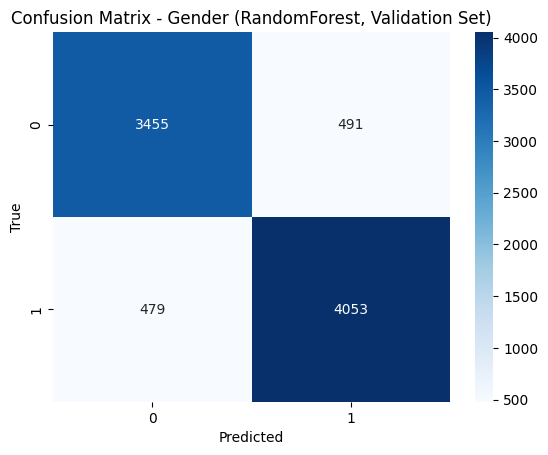


Fitting RandomForest male

Fitting RandomForest female


Predicting RandomForest on validation set: 100%|██████████| 8478/8478 [03:35<00:00, 39.31it/s]



RandomForest -  Age Prediction Report for male_masculine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.36      0.41      0.38       931
        20.0       0.24      0.24      0.24       848
        30.0       0.23      0.46      0.31       827
        40.0       0.26      0.28      0.27       690
        50.0       0.34      0.15      0.21       591
        60.0       0.62      0.04      0.08       416
        70.0       1.00      0.01      0.03       229

    accuracy                           0.28      4532
   macro avg       0.44      0.23      0.22      4532
weighted avg       0.35      0.28      0.26      4532



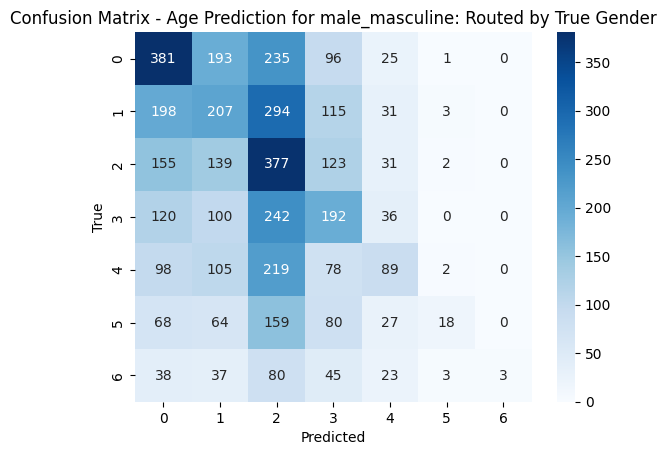


RandomForest -  Age Prediction Report for female_feminine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.59      0.60      0.59       671
        20.0       0.41      0.48      0.44       800
        30.0       0.43      0.57      0.49       788
        40.0       0.57      0.52      0.54       673
        50.0       0.62      0.52      0.57       600
        60.0       0.98      0.34      0.50       324
        70.0       1.00      0.33      0.50        90

    accuracy                           0.52      3946
   macro avg       0.66      0.48      0.52      3946
weighted avg       0.56      0.52      0.52      3946



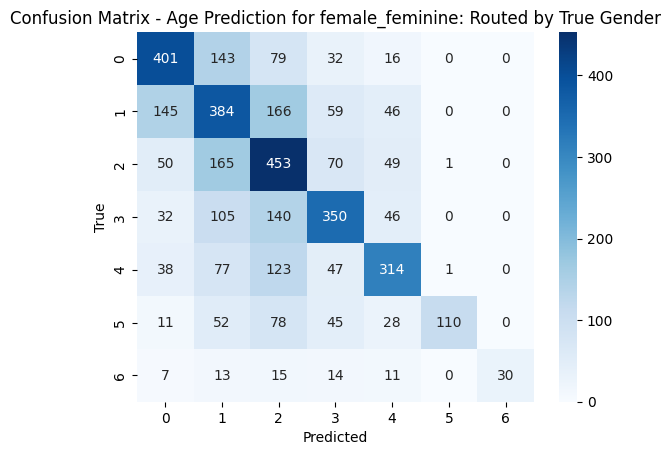


RandomForest -  Age Prediction Report for total: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.45      0.49      0.47      1602
        20.0       0.33      0.36      0.34      1648
        30.0       0.31      0.51      0.39      1615
        40.0       0.40      0.40      0.40      1363
        50.0       0.52      0.34      0.41      1191
        60.0       0.91      0.17      0.29       740
        70.0       1.00      0.10      0.19       319

    accuracy                           0.39      8478
   macro avg       0.56      0.34      0.36      8478
weighted avg       0.46      0.39      0.38      8478



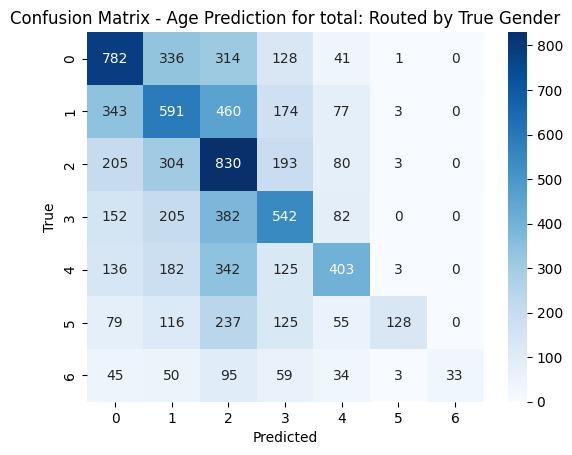


RandomForest -  Age Prediction Report for male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.34      0.36      0.35       931
        20.0       0.24      0.23      0.23       848
        30.0       0.23      0.46      0.31       827
        40.0       0.25      0.28      0.26       690
        50.0       0.30      0.15      0.20       591
        60.0       0.70      0.04      0.07       416
        70.0       1.00      0.01      0.03       229

    accuracy                           0.27      4532
   macro avg       0.44      0.22      0.21      4532
weighted avg       0.35      0.27      0.25      4532



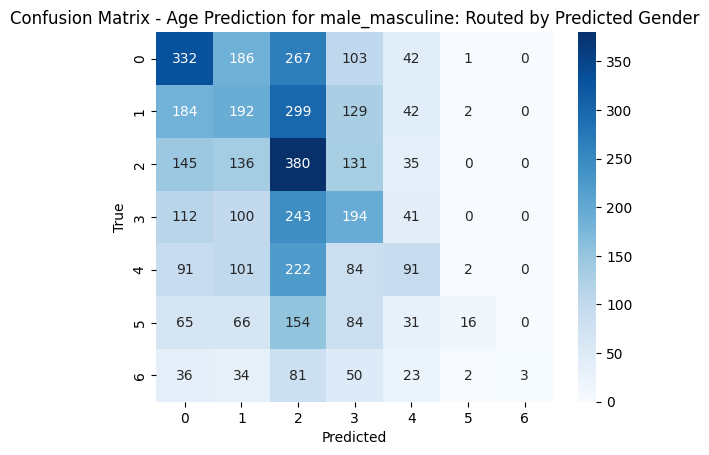


RandomForest -  Age Prediction Report for female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.52      0.59      0.55       671
        20.0       0.39      0.47      0.43       800
        30.0       0.41      0.55      0.47       788
        40.0       0.56      0.49      0.52       673
        50.0       0.65      0.47      0.54       600
        60.0       0.98      0.32      0.48       324
        70.0       1.00      0.33      0.50        90

    accuracy                           0.49      3946
   macro avg       0.64      0.46      0.50      3946
weighted avg       0.55      0.49      0.50      3946



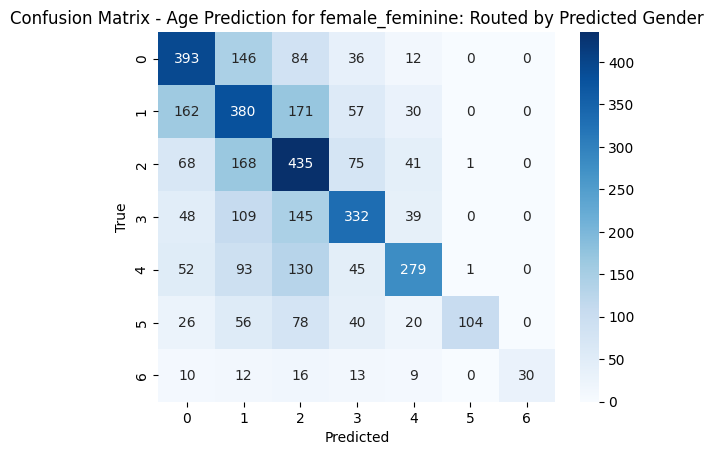


RandomForest -  Age Prediction Report for total: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.42      0.45      0.44      1602
        20.0       0.32      0.35      0.33      1648
        30.0       0.30      0.50      0.38      1615
        40.0       0.38      0.39      0.38      1363
        50.0       0.50      0.31      0.38      1191
        60.0       0.93      0.16      0.28       740
        70.0       1.00      0.10      0.19       319

    accuracy                           0.37      8478
   macro avg       0.55      0.32      0.34      8478
weighted avg       0.45      0.37      0.37      8478



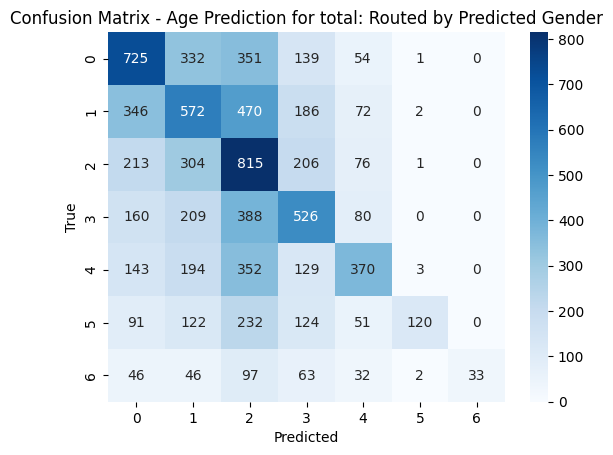


🔍 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0175


{'acc_true_gender': 0.3903043170559094,
 'acc_pred_gender': 0.3728473696626563,
 'routing_error_cost': 0.017456947393253097}

In [158]:
""" fit_predict_gender_age_pipeline(
    gender_model_class=RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced'),
    age_model_class_male=RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced'),
    age_model_class_female=RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced'),
    gender_model_name="RandomForest",
    age_model_name="RandomForest"
) """

fit_predict_gender_age_pipeline_with_joint_comparison(
    gender_model_class=RandomForestClassifier(n_estimators=100, random_state=27),
    age_model_class_male=RandomForestClassifier(n_estimators=100, random_state=27),
    age_model_class_female=RandomForestClassifier(n_estimators=100, random_state=27),
    gender_model_name="RandomForest",
    age_model_name="RandomForest"
)


KNN_by_age Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.89      0.83      0.86      4421
 male_masculine       0.89      0.93      0.91      6293

       accuracy                           0.89     10714
      macro avg       0.89      0.88      0.88     10714
   weighted avg       0.89      0.89      0.89     10714


KNN_by_age Gender Model - Validation Set:
                 precision    recall  f1-score   support

female_feminine       0.82      0.74      0.78       947
 male_masculine       0.83      0.88      0.86      1349

       accuracy                           0.82      2296
      macro avg       0.82      0.81      0.82      2296
   weighted avg       0.82      0.82      0.82      2296



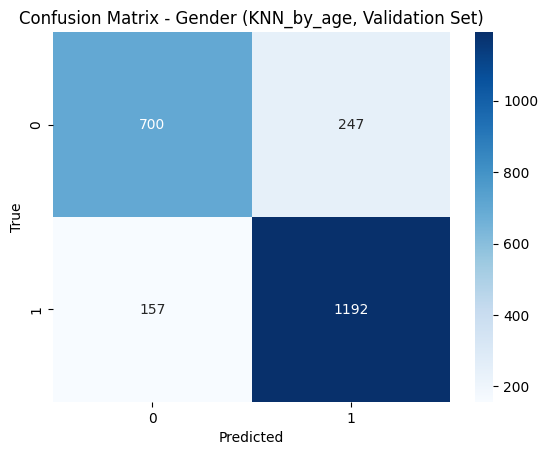


Fitting RandomForest male

Fitting RandomForest female


Predicting RandomForest on validation set: 100%|██████████| 2296/2296 [00:52<00:00, 43.97it/s]



RandomForest -  Age Prediction Report for male_masculine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.32      0.39      0.35       279
        20.0       0.25      0.24      0.25       255
        30.0       0.19      0.30      0.23       248
        40.0       0.17      0.19      0.18       207
        50.0       0.16      0.11      0.13       178
        60.0       0.00      0.00      0.00       125
        70.0       0.00      0.00      0.00        57

    accuracy                           0.23      1349
   macro avg       0.15      0.18      0.16      1349
weighted avg       0.19      0.23      0.21      1349



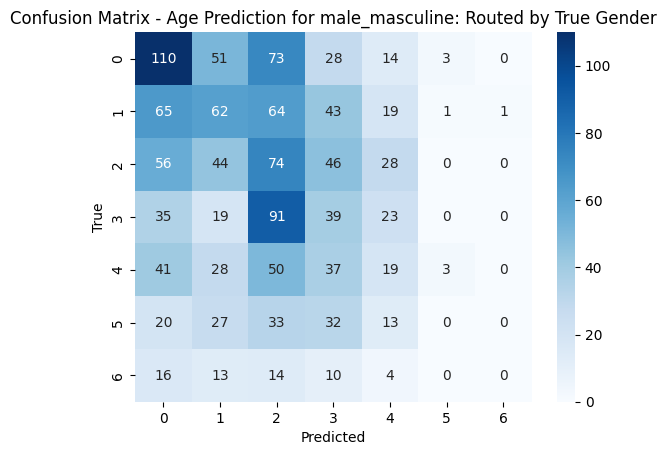


RandomForest -  Age Prediction Report for female_feminine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.25      0.11      0.15       139
        20.0       0.32      0.56      0.41       239
        30.0       0.28      0.44      0.34       214
        40.0       0.17      0.07      0.10       137
        50.0       0.28      0.17      0.21       133
        60.0       0.00      0.00      0.00        66
        70.0       0.00      0.00      0.00        19

    accuracy                           0.29       947
   macro avg       0.19      0.19      0.17       947
weighted avg       0.24      0.29      0.25       947



c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

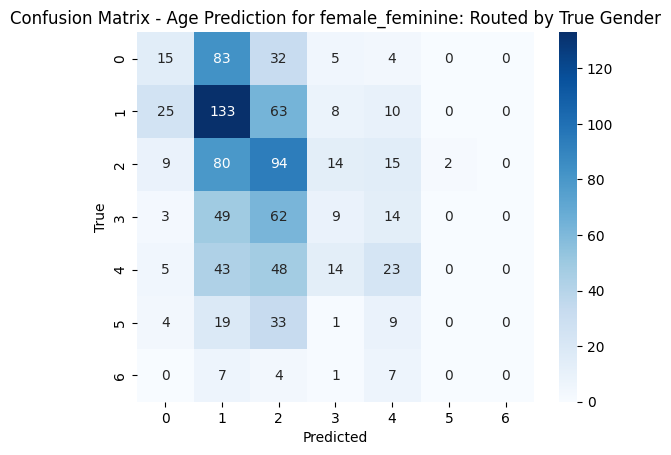


RandomForest -  Age Prediction Report for total: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.31      0.30      0.30       418
        20.0       0.30      0.39      0.34       494
        30.0       0.23      0.36      0.28       462
        40.0       0.17      0.14      0.15       344
        50.0       0.21      0.14      0.16       311
        60.0       0.00      0.00      0.00       191
        70.0       0.00      0.00      0.00        76

    accuracy                           0.25      2296
   macro avg       0.17      0.19      0.18      2296
weighted avg       0.22      0.25      0.23      2296



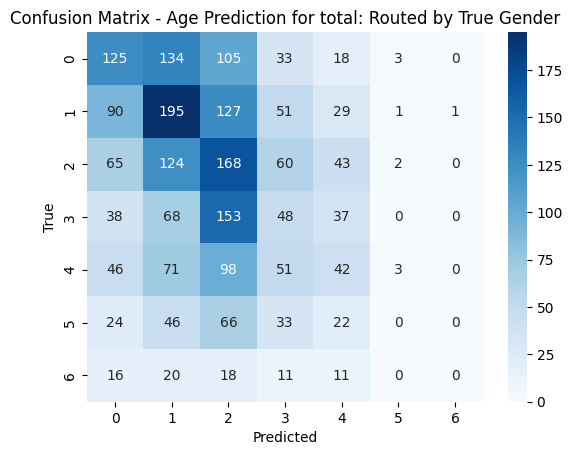


RandomForest -  Age Prediction Report for male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.29      0.31      0.30       279
        20.0       0.24      0.27      0.26       255
        30.0       0.18      0.29      0.22       248
        40.0       0.17      0.18      0.18       207
        50.0       0.16      0.12      0.14       178
        60.0       0.00      0.00      0.00       125
        70.0       0.00      0.00      0.00        57

    accuracy                           0.21      1349
   macro avg       0.15      0.17      0.16      1349
weighted avg       0.19      0.21      0.20      1349



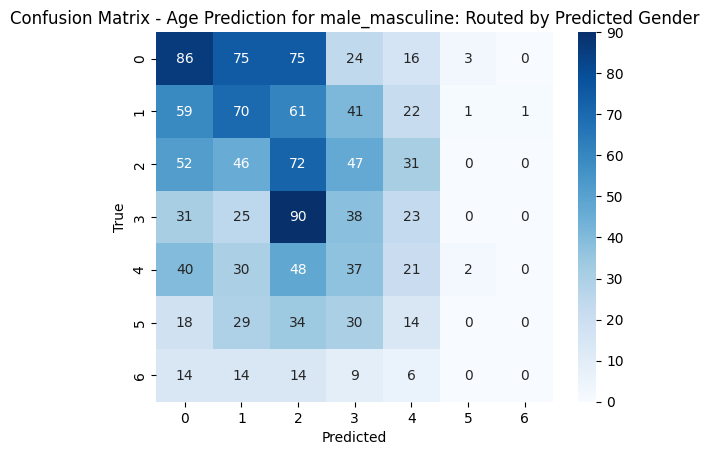


RandomForest -  Age Prediction Report for female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.18      0.16      0.17       139
        20.0       0.31      0.54      0.40       239
        30.0       0.27      0.38      0.31       214
        40.0       0.19      0.09      0.12       137
        50.0       0.22      0.08      0.12       133
        60.0       0.00      0.00      0.00        66
        70.0       0.00      0.00      0.00        19

    accuracy                           0.27       947
   macro avg       0.17      0.18      0.16       947
weighted avg       0.22      0.27      0.23       947



c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

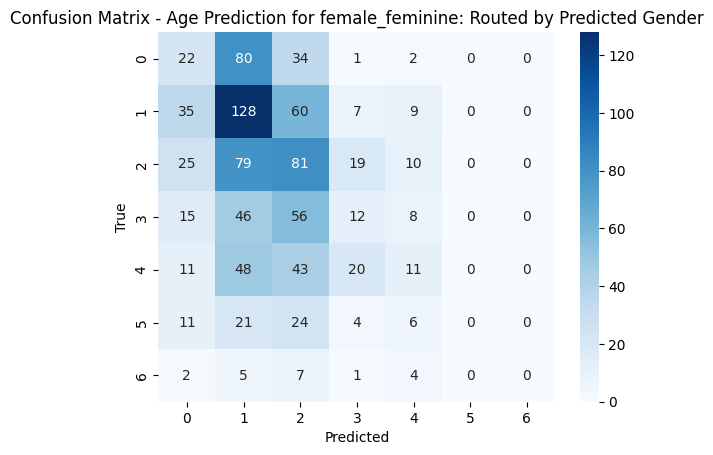


RandomForest -  Age Prediction Report for total: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.26      0.26      0.26       418
        20.0       0.28      0.40      0.33       494
        30.0       0.22      0.33      0.26       462
        40.0       0.17      0.15      0.16       344
        50.0       0.17      0.10      0.13       311
        60.0       0.00      0.00      0.00       191
        70.0       0.00      0.00      0.00        76

    accuracy                           0.24      2296
   macro avg       0.16      0.18      0.16      2296
weighted avg       0.20      0.24      0.21      2296



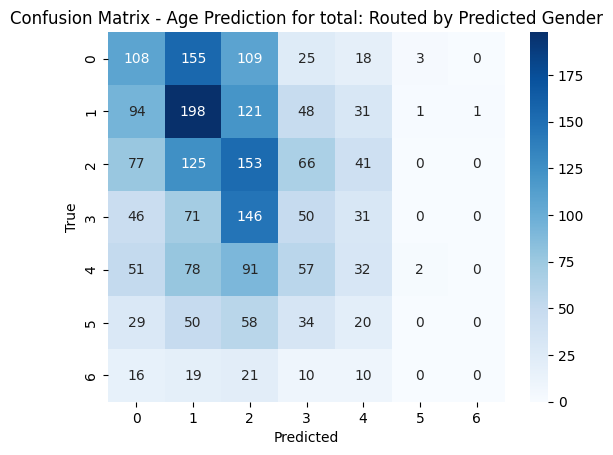


🔍 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0161


{'acc_true_gender': 0.25174216027874563,
 'acc_pred_gender': 0.23562717770034844,
 'routing_error_cost': 0.01611498257839719}

In [97]:
""" fit_predict_gender_age_pipeline(
    gender_model_class=KNeighborsClassifier(n_neighbors=5),
    age_model_class_male=RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced'),
    age_model_class_female=RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced'),
    gender_model_name="KNN_by_age",
    age_model_name="RandomForest"
) """


fit_predict_gender_age_pipeline_with_joint_comparison(
    gender_model_class=KNeighborsClassifier(n_neighbors=5),
    age_model_class_male=RandomForestClassifier(n_estimators=100, random_state=27),
    age_model_class_female=RandomForestClassifier(n_estimators=100, random_state=27),
    gender_model_name="KNN_by_age",
    age_model_name="RandomForest")


MLPClassifier for Gender Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.99      1.00      0.99     18413
 male_masculine       1.00      0.99      1.00     21147

       accuracy                           0.99     39560
      macro avg       0.99      0.99      0.99     39560
   weighted avg       0.99      0.99      0.99     39560


MLPClassifier for Gender Gender Model - Validation Set:
                 precision    recall  f1-score   support

female_feminine       0.88      0.92      0.90      3946
 male_masculine       0.93      0.89      0.91      4532

       accuracy                           0.90      8478
      macro avg       0.90      0.90      0.90      8478
   weighted avg       0.90      0.90      0.90      8478



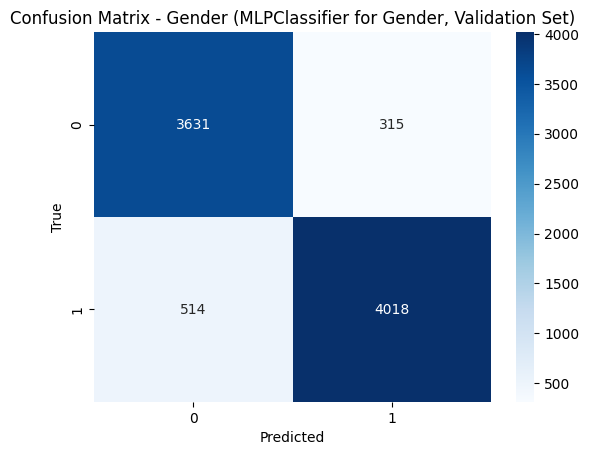


Fitting MLPClassifier for Age male

Fitting MLPClassifier for Age female


Predicting MLPClassifier for Age on validation set: 100%|██████████| 8478/8478 [01:20<00:00, 105.37it/s]



MLPClassifier for Age -  Age Prediction Report for male_masculine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.47      0.26      0.34       931
        20.0       0.30      0.16      0.21       848
        30.0       0.23      0.30      0.26       827
        40.0       0.24      0.35      0.28       690
        50.0       0.23      0.36      0.28       591
        60.0       0.27      0.29      0.28       416
        70.0       0.39      0.21      0.28       229

    accuracy                           0.28      4532
   macro avg       0.30      0.28      0.27      4532
weighted avg       0.30      0.28      0.28      4532



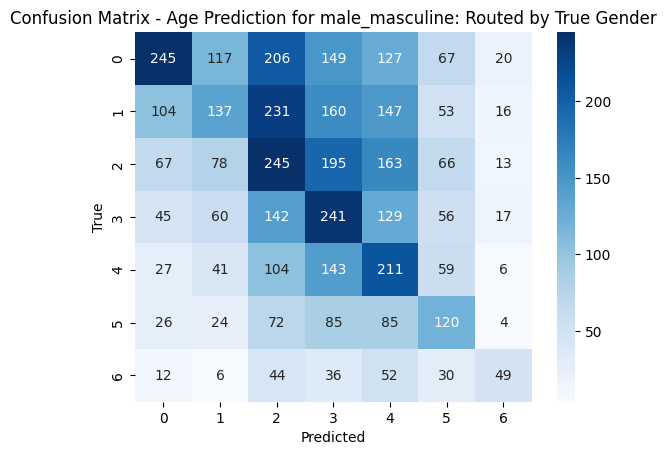


MLPClassifier for Age -  Age Prediction Report for female_feminine: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.52      0.52      0.52       671
        20.0       0.41      0.37      0.39       800
        30.0       0.44      0.42      0.43       788
        40.0       0.45      0.49      0.47       673
        50.0       0.43      0.52      0.47       600
        60.0       0.46      0.38      0.41       324
        70.0       0.49      0.39      0.43        90

    accuracy                           0.45      3946
   macro avg       0.46      0.44      0.45      3946
weighted avg       0.45      0.45      0.45      3946



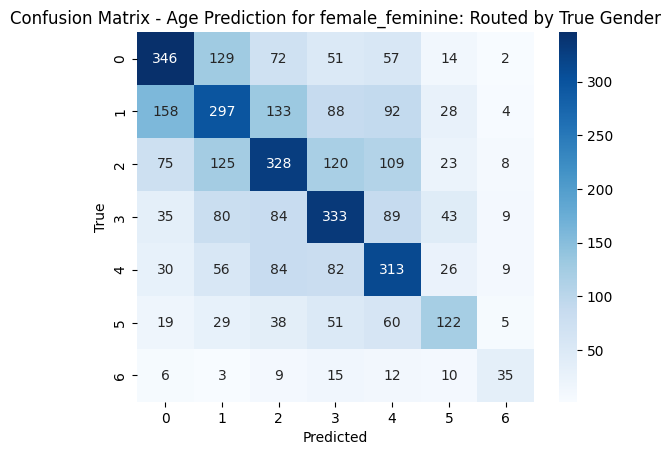


MLPClassifier for Age -  Age Prediction Report for total: Routed by True Gender
              precision    recall  f1-score   support

        10.0       0.49      0.37      0.42      1602
        20.0       0.37      0.26      0.31      1648
        30.0       0.32      0.35      0.34      1615
        40.0       0.33      0.42      0.37      1363
        50.0       0.32      0.44      0.37      1191
        60.0       0.34      0.33      0.33       740
        70.0       0.43      0.26      0.33       319

    accuracy                           0.36      8478
   macro avg       0.37      0.35      0.35      8478
weighted avg       0.37      0.36      0.36      8478



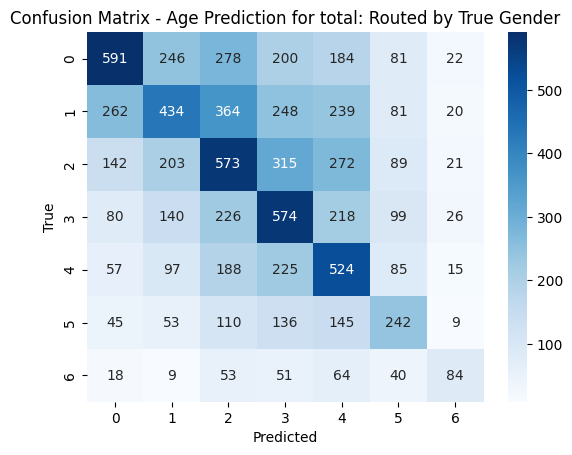


MLPClassifier for Age -  Age Prediction Report for male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.44      0.23      0.30       931
        20.0       0.29      0.17      0.22       848
        30.0       0.24      0.30      0.27       827
        40.0       0.24      0.36      0.29       690
        50.0       0.22      0.36      0.27       591
        60.0       0.27      0.27      0.27       416
        70.0       0.37      0.21      0.27       229

    accuracy                           0.27      4532
   macro avg       0.30      0.27      0.27      4532
weighted avg       0.30      0.27      0.27      4532



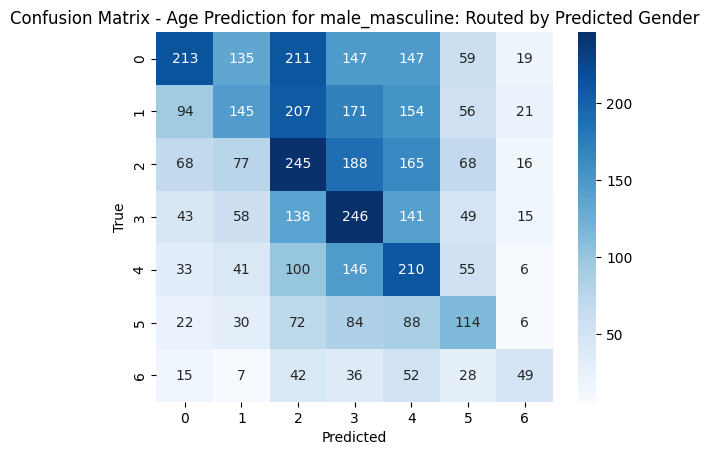


MLPClassifier for Age -  Age Prediction Report for female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.51      0.50      0.51       671
        20.0       0.41      0.36      0.38       800
        30.0       0.42      0.41      0.42       788
        40.0       0.45      0.48      0.46       673
        50.0       0.42      0.51      0.46       600
        60.0       0.42      0.36      0.39       324
        70.0       0.43      0.38      0.40        90

    accuracy                           0.44      3946
   macro avg       0.44      0.43      0.43      3946
weighted avg       0.44      0.44      0.44      3946



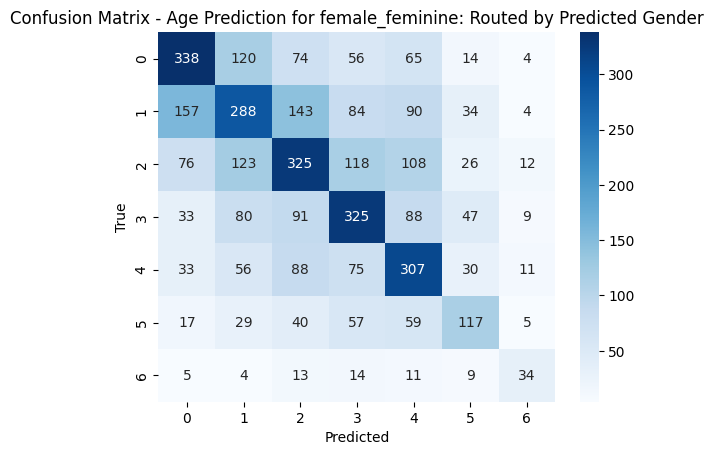


MLPClassifier for Age -  Age Prediction Report for total: Routed by Predicted Gender
              precision    recall  f1-score   support

        10.0       0.48      0.34      0.40      1602
        20.0       0.36      0.26      0.30      1648
        30.0       0.32      0.35      0.33      1615
        40.0       0.33      0.42      0.37      1363
        50.0       0.31      0.43      0.36      1191
        60.0       0.33      0.31      0.32       740
        70.0       0.39      0.26      0.31       319

    accuracy                           0.35      8478
   macro avg       0.36      0.34      0.34      8478
weighted avg       0.36      0.35      0.35      8478



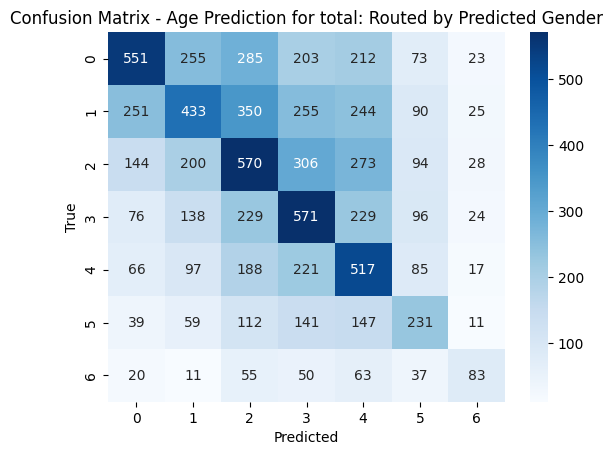


🔍 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0078


{'acc_true_gender': 0.35645199339466854,
 'acc_pred_gender': 0.3486671384760557,
 'routing_error_cost': 0.00778485491861286}

In [159]:
fit_predict_gender_age_pipeline_with_joint_comparison(
    MLPClassifier(hidden_layer_sizes=(128, 64, 32),
              max_iter=500,
              random_state=27,
              batch_size=32,
              learning_rate='adaptive',
              learning_rate_init=0.0005,
              alpha=0.001),
    MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32),
                max_iter=4000,
                random_state=27,
                batch_size=32,
                learning_rate='adaptive',
                learning_rate_init=0.0005,
                alpha=0.001,
                early_stopping=True,
                validation_fraction=0.1),
    MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                max_iter=2000,
                random_state=27,
                batch_size=32,
                learning_rate='adaptive',
                learning_rate_init=0.0005,
                alpha=0.001,
                early_stopping=True,
                validation_fraction=0.1),
    "MLPClassifier for Gender",
    "MLPClassifier for Age"
)

## Soft Age Prediction

In [160]:
def fit_predict_gender_age_pipeline_with_soft_feature(
    gender_model_class,
    age_model_class,
    gender_model_name="GenderModel",
    age_model_name="AgeModel"
):
    # ====== Fit gender model ======
    gender_model = clone(gender_model_class)
    pipe_gender = make_pipeline(preprocessing, gender_model)
    pipe_gender.fit(X_train, y_train['gender'])

    # Predict gender probability (for 'male_masculine')
    prob_gender_train = pipe_gender.predict_proba(X_train)[:, 1]
    prob_gender_val = pipe_gender.predict_proba(X_val)[:, 1]
    true_gender_binary_val = (y_val['gender'] == 'male_masculine').astype(int)

    # ====== Evaluate gender model ======
    predicted_gender_val = pipe_gender.predict(X_val)
    print(f"\n{gender_model_name} Gender Model - Validation Set Classification Report:")
    print(classification_report(y_val['gender'], predicted_gender_val))

    auc_score = roc_auc_score(true_gender_binary_val, prob_gender_val)
    logloss = log_loss(true_gender_binary_val, prob_gender_val)
    print(f"AUC-ROC for Gender Probabilities: {auc_score:.4f}")
    print(f"Log Loss for Gender Probabilities: {logloss:.4f}")

    RocCurveDisplay.from_predictions(true_gender_binary_val, prob_gender_val)
    plt.title("ROC Curve - Gender Probabilities")
    plt.show()

    prob_true, prob_pred = calibration_curve(true_gender_binary_val, prob_gender_val, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve - Gender Probabilities")
    plt.show()

    # ====== Append gender prob to features ======
    X_train_aug = X_train.copy()
    X_val_aug = X_val.copy()
    X_train_aug['prob_gender_male'] = prob_gender_train
    X_val_aug['prob_gender_male'] = prob_gender_val

    # ====== Fit age model ======
    age_model = make_pipeline(preprocessing, clone(age_model_class))
    print(f"\nFitting {age_model_name} with gender probability feature")
    age_model.fit(X_train_aug, y_train['age'])
    evaluate_models(y_train['age'], {age_model_name : age_model.predict(X_train_aug)}, (12, 8), False, "Training Set")

    # ====== Predict age ======
    y_pred = age_model.predict(X_val_aug)
    return evaluate_models(y_val['age'], {age_model_name : y_pred}, (12, 8), True, "Validation Set")




KNN by Gender Gender Model - Validation Set Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.87      0.88      0.87      3946
 male_masculine       0.89      0.89      0.89      4532

       accuracy                           0.88      8478
      macro avg       0.88      0.88      0.88      8478
   weighted avg       0.88      0.88      0.88      8478

AUC-ROC for Gender Probabilities: 0.9431
Log Loss for Gender Probabilities: 0.7409


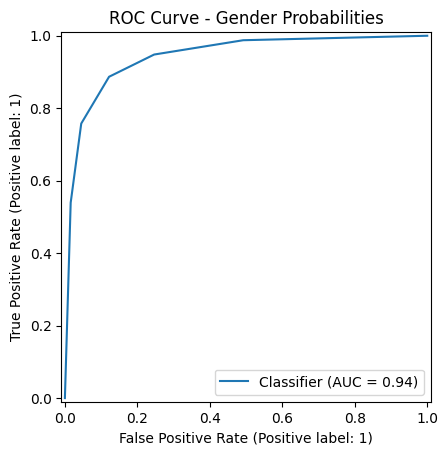

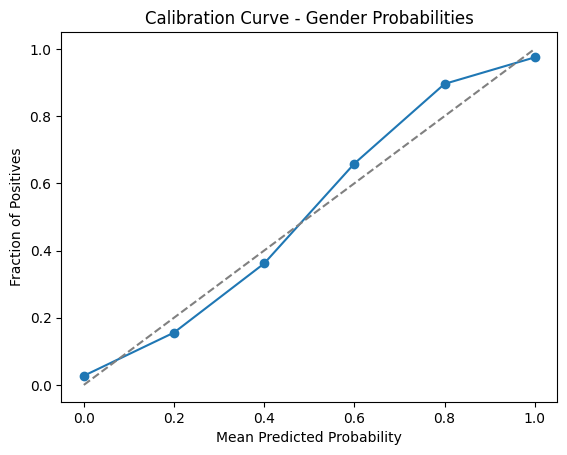


Fitting KNN by Age with gender probability feature

===== KNN by Age: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.63      0.81      0.71      7479
        20.0       0.65      0.62      0.64      7684
        30.0       0.66      0.65      0.66      7534
        40.0       0.69      0.66      0.67      6359
        50.0       0.74      0.66      0.70      5559
        60.0       0.78      0.66      0.71      3457
        70.0       0.80      0.71      0.75      1488

    accuracy                           0.68     39560
   macro avg       0.71      0.68      0.69     39560
weighted avg       0.68      0.68      0.68     39560


===== KNN by Age: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.44      0.59      0.51      1602
        20.0       0.38      0.35      0.36      1648
        30.0       0.42      0.43      0.42      1615
        40

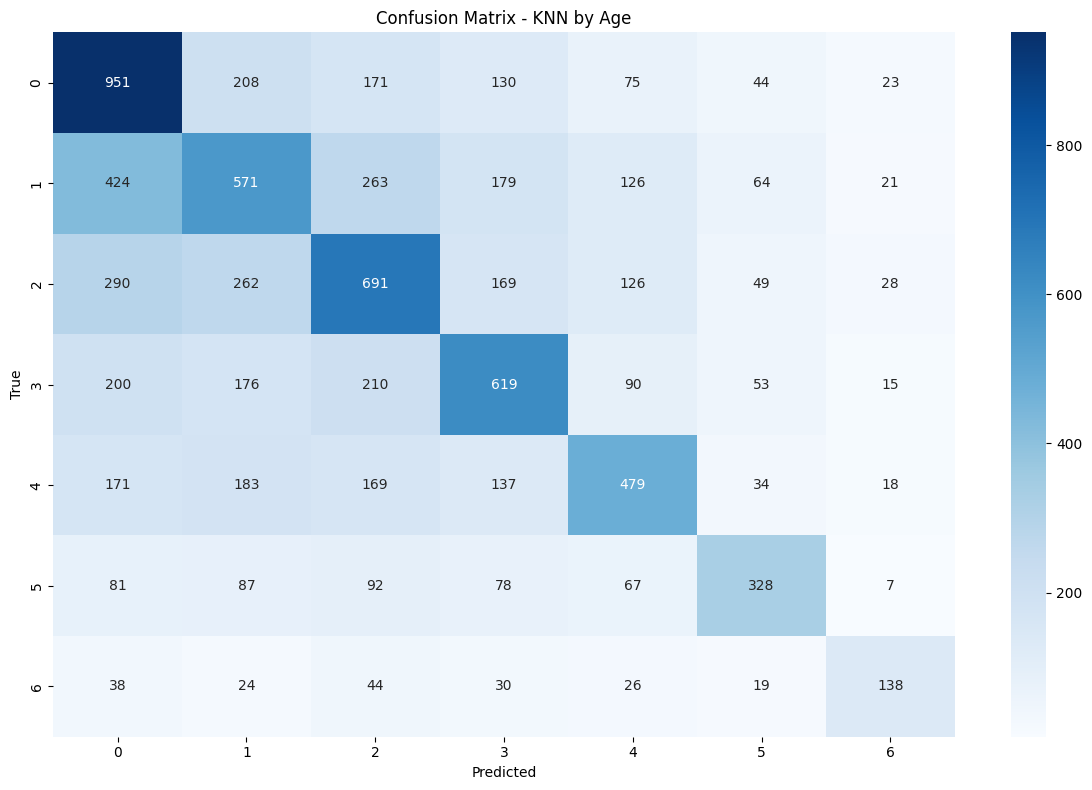

<Figure size 1000x600 with 0 Axes>

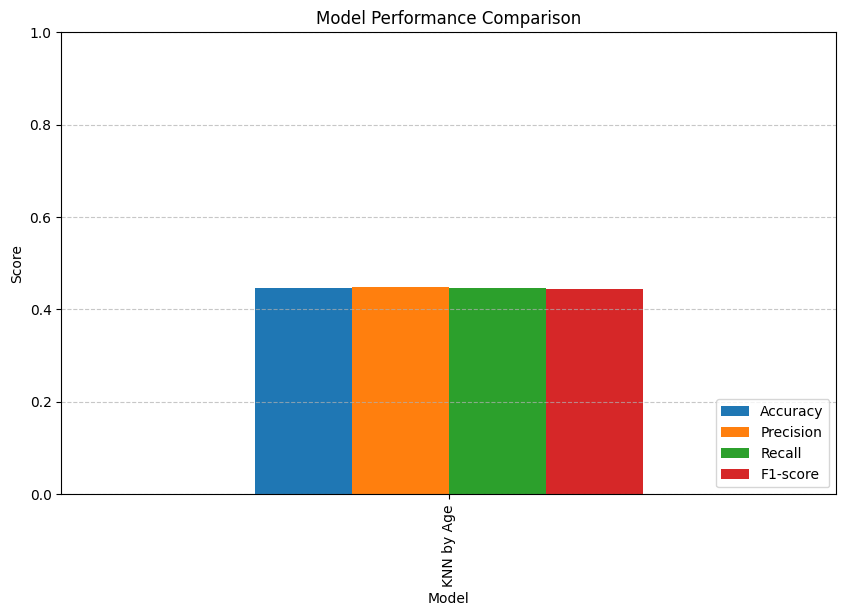

,Model,Accuracy,Precision,Recall,F1-score
0,KNN by Age,0.4455,0.4485,0.4455,0.4434


In [161]:
fit_predict_gender_age_pipeline_with_soft_feature(KNeighborsClassifier(n_neighbors=5), KNeighborsClassifier(n_neighbors=5), "KNN by Gender", "KNN by Age")


Random Forest for Gender Gender Model - Validation Set Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.88      0.88      0.88      3946
 male_masculine       0.89      0.89      0.89      4532

       accuracy                           0.89      8478
      macro avg       0.89      0.88      0.89      8478
   weighted avg       0.89      0.89      0.89      8478

AUC-ROC for Gender Probabilities: 0.9522
Log Loss for Gender Probabilities: 0.3281


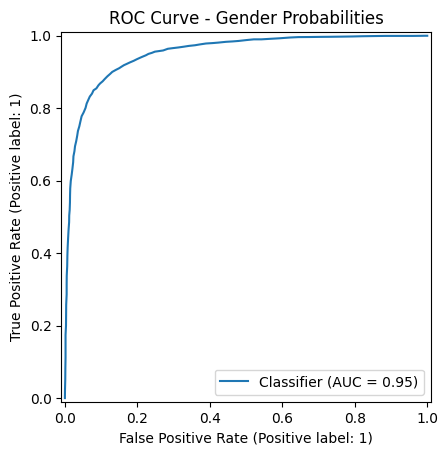

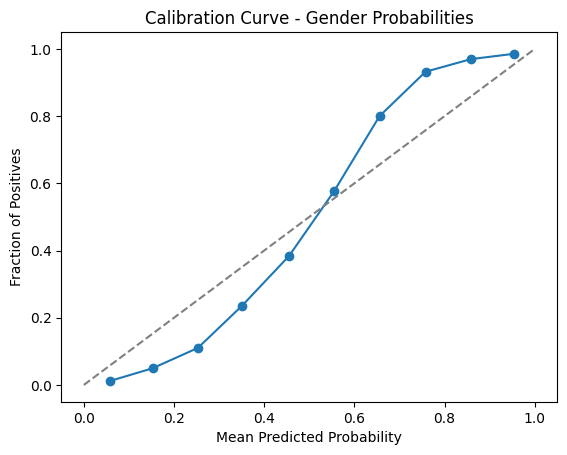


Fitting MLP for Age with gender probability feature

===== MLP for Age: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.53      0.64      0.58      7479
        20.0       0.42      0.44      0.43      7684
        30.0       0.43      0.43      0.43      7534
        40.0       0.44      0.39      0.41      6359
        50.0       0.45      0.49      0.47      5559
        60.0       0.49      0.34      0.40      3457
        70.0       0.58      0.35      0.44      1488

    accuracy                           0.46     39560
   macro avg       0.48      0.44      0.45     39560
weighted avg       0.46      0.46      0.46     39560


===== MLP for Age: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.38      0.47      0.42      1602
        20.0       0.29      0.30      0.29      1648
        30.0       0.27      0.29      0.28      1615
       

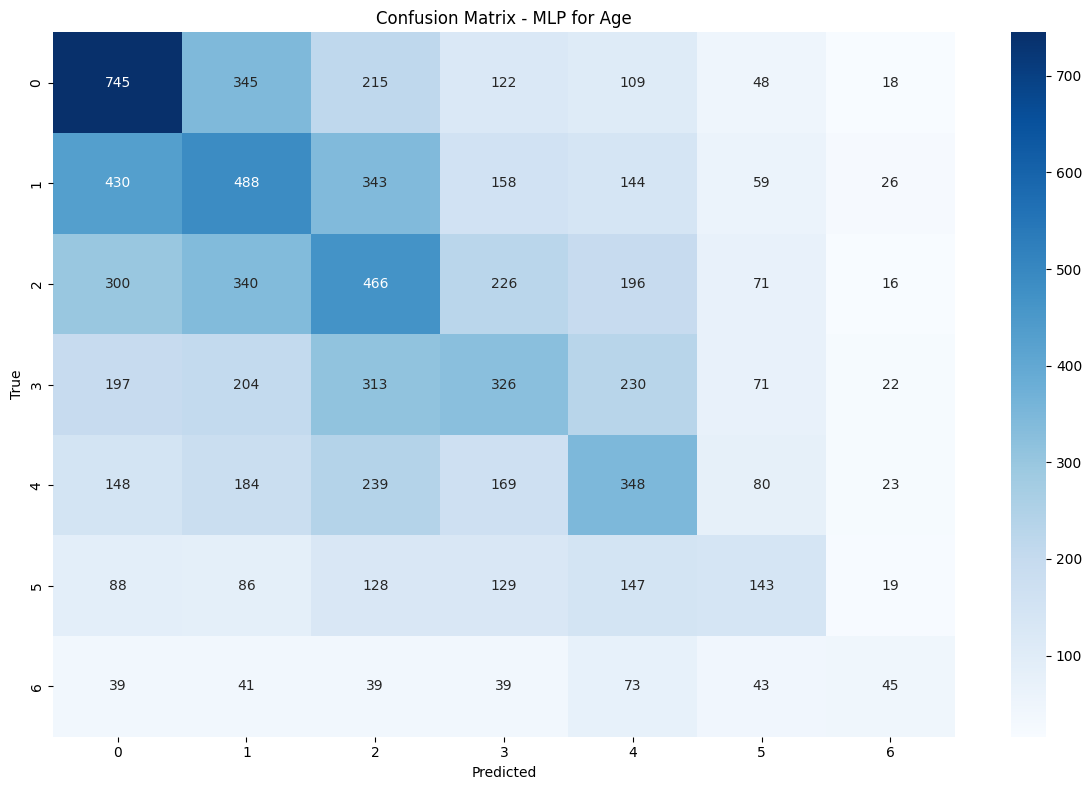

<Figure size 1000x600 with 0 Axes>

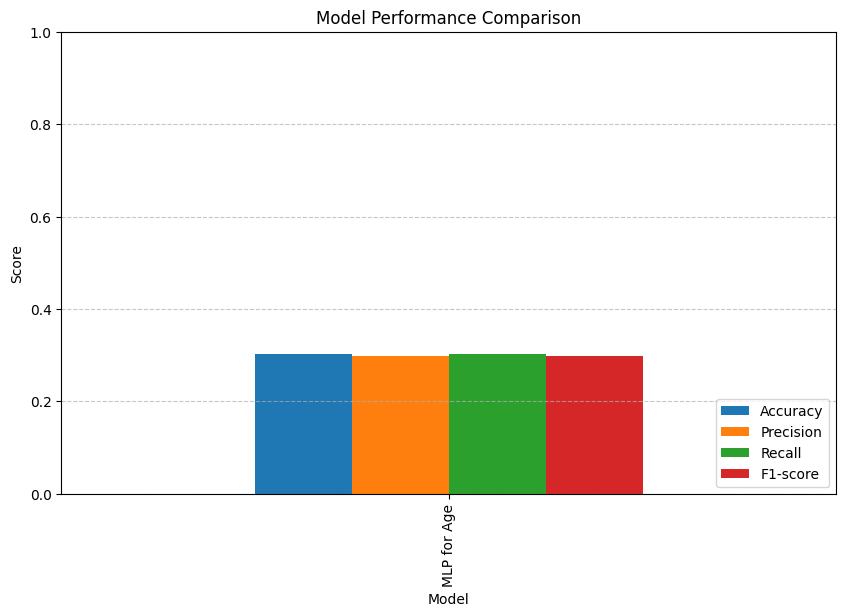

,Model,Accuracy,Precision,Recall,F1-score
0,MLP for Age,0.3021,0.2977,0.3021,0.2974


In [162]:
fit_predict_gender_age_pipeline_with_soft_feature(
    RandomForestClassifier(n_estimators=100, random_state=27),
    MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=2000, random_state=27, batch_size=32, learning_rate='adaptive', learning_rate_init=0.0005, alpha=0.001, early_stopping=True, validation_fraction=0.1),
    "Random Forest for Gender", "MLP for Age")


MLP for gender Gender Model - Validation Set Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.88      0.92      0.90      3946
 male_masculine       0.93      0.89      0.91      4532

       accuracy                           0.90      8478
      macro avg       0.90      0.90      0.90      8478
   weighted avg       0.90      0.90      0.90      8478

AUC-ROC for Gender Probabilities: 0.9553
Log Loss for Gender Probabilities: 0.7519


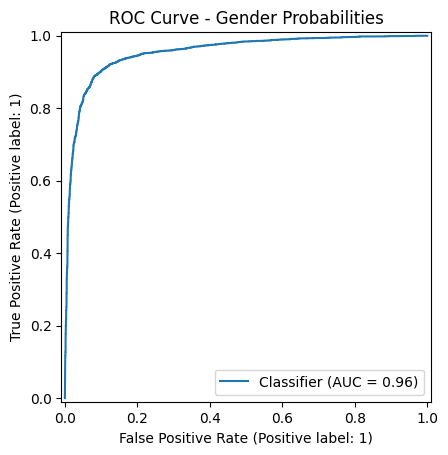

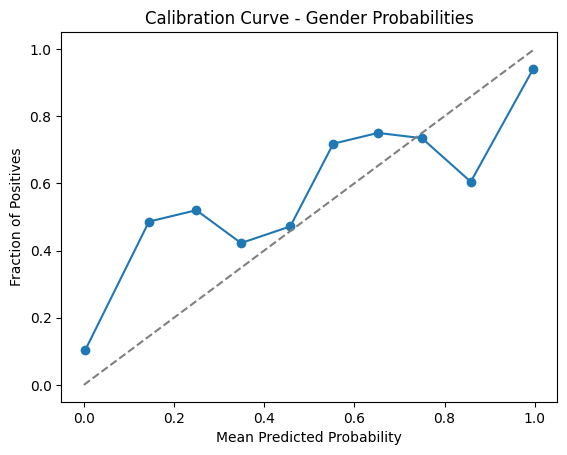


Fitting KNN for Age with gender probability feature

===== KNN for Age: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.64      0.82      0.72      7479
        20.0       0.65      0.62      0.64      7684
        30.0       0.66      0.66      0.66      7534
        40.0       0.70      0.66      0.68      6359
        50.0       0.74      0.66      0.70      5559
        60.0       0.78      0.66      0.72      3457
        70.0       0.80      0.72      0.76      1488

    accuracy                           0.68     39560
   macro avg       0.71      0.69      0.70     39560
weighted avg       0.69      0.68      0.68     39560


===== KNN for Age: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.44      0.59      0.50      1602
        20.0       0.37      0.35      0.36      1648
        30.0       0.41      0.42      0.42      1615
       

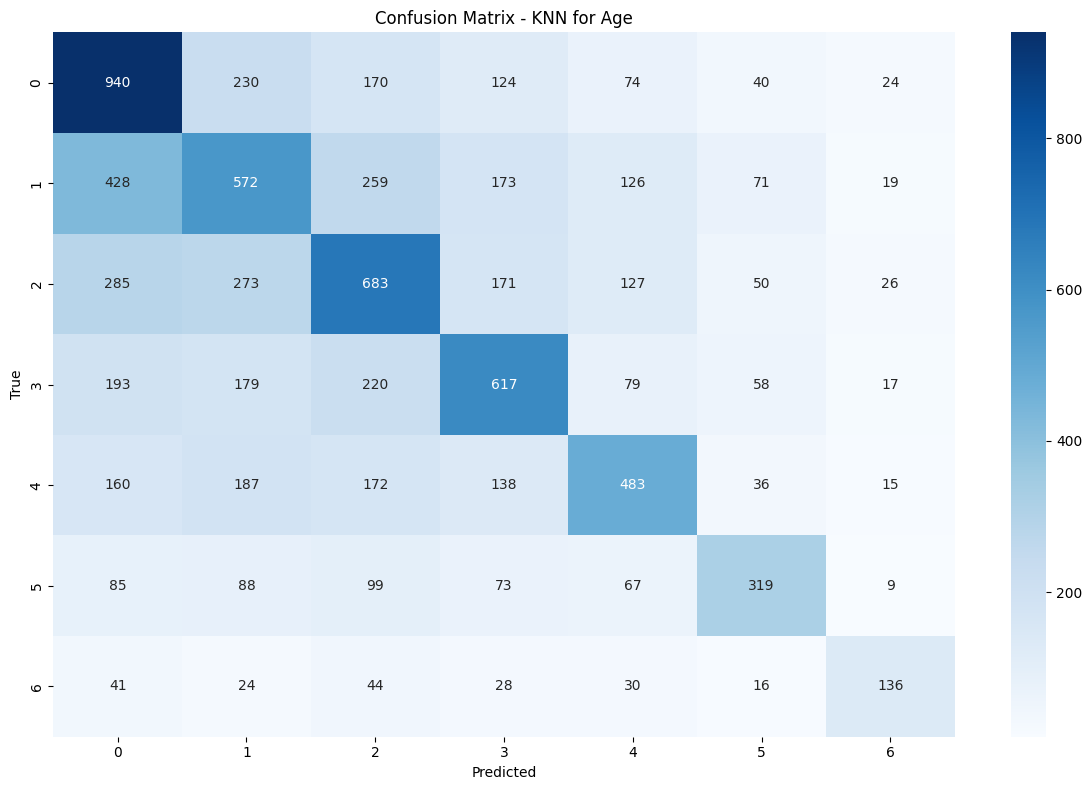

<Figure size 1000x600 with 0 Axes>

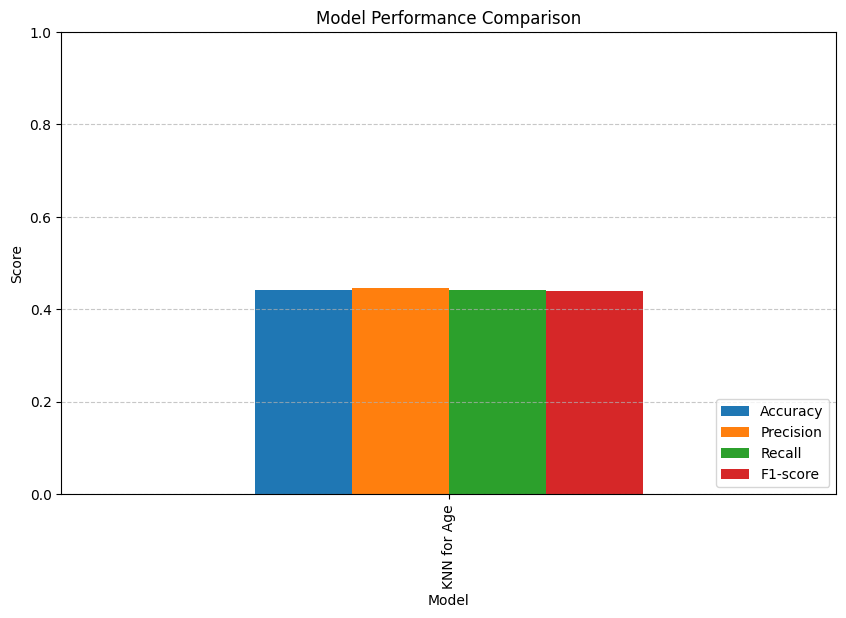

,Model,Accuracy,Precision,Recall,F1-score
0,KNN for Age,0.4423,0.4456,0.4423,0.4405


In [163]:
fit_predict_gender_age_pipeline_with_soft_feature(MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=27, batch_size=32, learning_rate='adaptive', learning_rate_init=0.0005, alpha=0.001), KNeighborsClassifier(n_neighbors=5), "MLP for gender", "KNN for Age")
                                                


MLP for Gender Gender Model - Validation Set Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.88      0.92      0.90      3946
 male_masculine       0.93      0.89      0.91      4532

       accuracy                           0.90      8478
      macro avg       0.90      0.90      0.90      8478
   weighted avg       0.90      0.90      0.90      8478

AUC-ROC for Gender Probabilities: 0.9553
Log Loss for Gender Probabilities: 0.7519


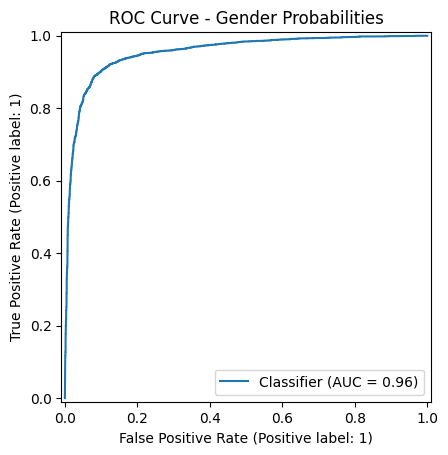

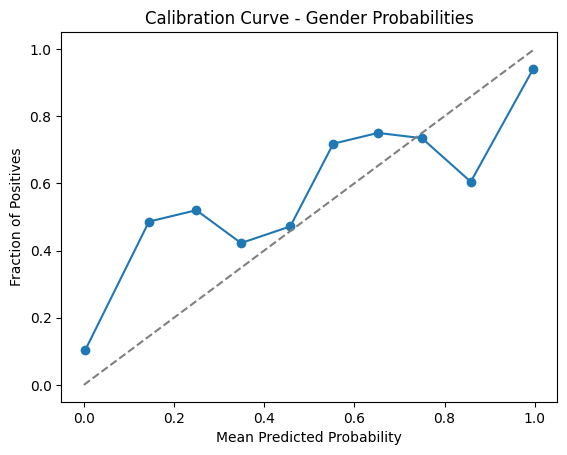


Fitting MLP for Age with gender probability feature

===== MLP for Age: Training Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.60      0.72      0.66      7479
        20.0       0.53      0.49      0.51      7684
        30.0       0.51      0.55      0.53      7534
        40.0       0.52      0.56      0.54      6359
        50.0       0.60      0.54      0.57      5559
        60.0       0.66      0.46      0.54      3457
        70.0       0.71      0.54      0.61      1488

    accuracy                           0.56     39560
   macro avg       0.59      0.55      0.56     39560
weighted avg       0.57      0.56      0.56     39560


===== MLP for Age: Validation Set =====
Classification Report:
              precision    recall  f1-score   support

        10.0       0.39      0.46      0.43      1602
        20.0       0.29      0.25      0.27      1648
        30.0       0.27      0.30      0.29      1615
       

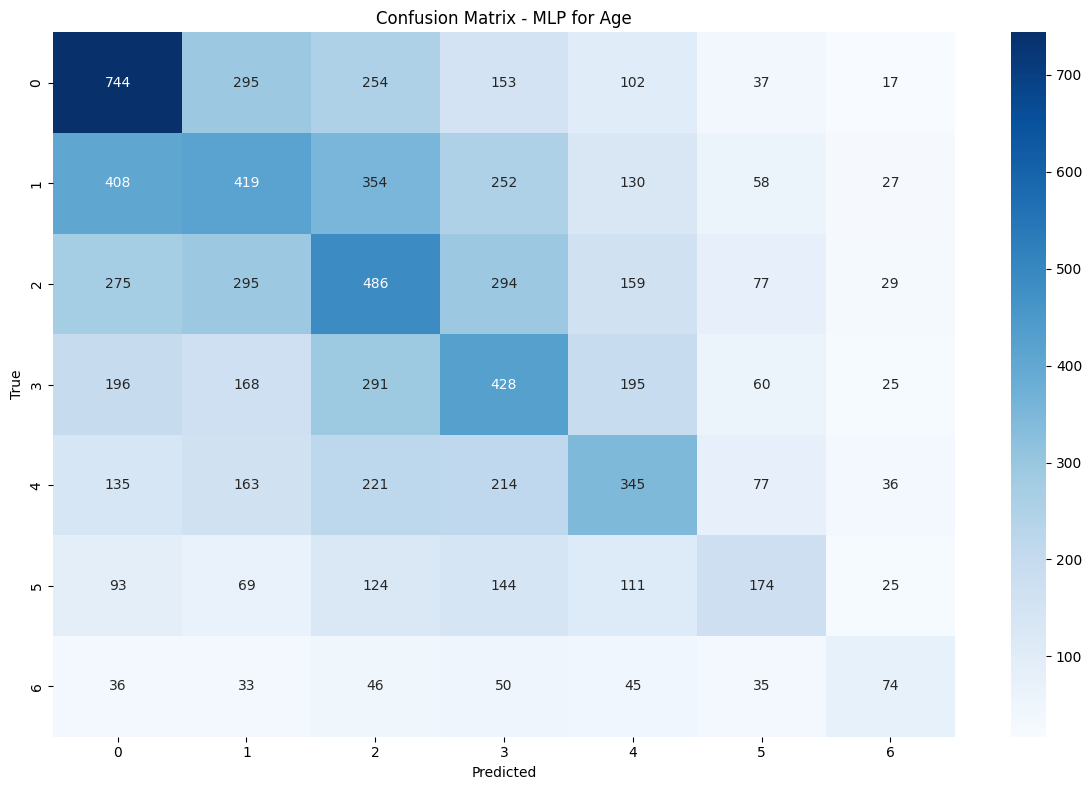

<Figure size 1000x600 with 0 Axes>

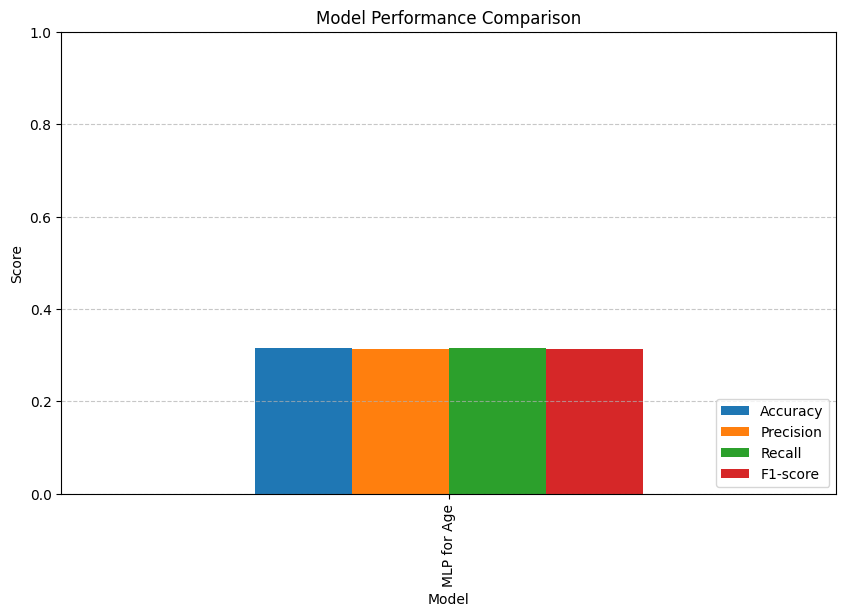

,Model,Accuracy,Precision,Recall,F1-score
0,MLP for Age,0.3149,0.3138,0.3149,0.3122


In [164]:
fit_predict_gender_age_pipeline_with_soft_feature(
    MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=27, batch_size=32, learning_rate='adaptive', learning_rate_init=0.0005, alpha=0.001),
    MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=2000, random_state=27, batch_size=32, learning_rate='adaptive', learning_rate_init=0.0005, alpha=0.001, early_stopping=True, validation_fraction=0.1),
    "MLP for Gender", "MLP for Age"
)